# Flatiron Capstone Project – Notebook #4: Modeling

Student name: **Angelo Turri**

Student pace: **self paced**

Project finish date: **1/19/24**

Instructor name: **Mark Barbour**

# Instructions

Due to the size of this project, there are four notebooks instead of one. The proper order to execute these notebooks is as follows:

- **Gathering Data**
- **Preprocessing**
- **Feature Engineering**
- **Modeling** <---- You are here

# Modeling

The model of choice was Linear Regression. The advantages of this model for this project are:

- It provides coefficients for all independent variables, making it interpretable;
- The coefficients can be positive or negative, so we know whether the independent variable positively or negatively impacted the target

We fit one model for each set of features, so we could analyze the model coefficients separately for single-, two-, and three-word phrases.

# Metrics
I use several metrics to judge the performance of a model:

- MAE (mean absolute error): the average amount the model is off by when it makes a prediction. No minimum, no maximum.
- R-squared: how much variance in the observed values a model explains. The loweset value is 0, which essentialy means the model is completely clueless. The highest value is 1, which means the model explains all the variance seen in the observed values – and that all of its predictions are exactly correct.

### First Iteration

We started by using the "score" target variable. The results were very poor, with R-squared values of <0.1 for each model. These are so abysmal that I am not going to go into details for any of these models.

### Second Iteration

The second iteration of modeling used the "vader" target variable. The results were much better:

- Test R-squared for unigrams model: 0.245
- Test R-squared for bigrams model: 0.166
- Test R-squared for trigrams model: 0.326

Mean Absolute Error results:

- Test MAE for unigrams model: 0.33
- Test MAE for bigrams model: 0.433
- Test MAE for trigrams model: 0.363

### Third Iteration

The third iteration of modeling also used the "vader" target variable, but I eliminated all neutral scores from the dataset. The results were marginally better for R^2 but the MAE scores got slightly worse:

- Test R-squared for unigrams model: 0.249 (+0.003)
- Test R-squared for bigrams model: 0.168 (+0.002)
- Test R-squared for trigrams model: 0.344 (+0.018)

Mean Absolute Error results:

- Test MAE for unigrams model: 0.408 (+0.078)
- Test MAE for bigrams model: 0.468 (+0.035)
- Test MAE for trigrams model: 0.406 (+0.043)

### Fourth Iteration

The fourth iteration of modeling performed a hyperparameter grid search with the much faster SGDRegressor (also a linear regression model – just faster than the OLS version, and without significance values for the coefficients). The same data in the previous iteration was used for this one (with neutral VADER sentiment values removed). This iteration did not yield any improvements. All values were the same or slightly worse.

- Test R-squared for unigrams model: 0.249 (+0.00)
- Test R-squared for bigrams model: 0.168 (+0.00)
- Test R-squared for trigrams model: 0.333 (-0.011)

Mean Absolute Error results:

- Test MAE for unigrams model: 0.408 (+0.00)
- Test MAE for bigrams model: 0.469 (+0.001)
- Test MAE for trigrams model: 0.424 (+0.018)

# Importing Packages

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import json
import numpy as np

from IPython.display import clear_output, display_html, Markdown, display
import time
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from statsmodels.regression import linear_model as lr

import joblib

In [2]:
# Random state for any function that uses one
state = 42

In [3]:
def linear_model(x, y):
    
    """
    1) Performs a train-test split.
    2) Initializes a linear regression model.
    3) Fits the model.
    4) Selects only significant (p<0.05) coefficients.
    5) Sorts coefficients into positive and negative.
    6) Calculates predictions for train and test sets.
    7) Calculates MAE and RMSE error metrics for both sets of predictions.
    8) Calculates residuals for both sets of predictions.
    9) Returns a dictionary with all this information.
    """
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=state, test_size=0.2)
    target = y.name
    formula = f"{target} ~ " + ' + '.join([col for col in X.columns])

    # Fits model
    base_model = lr.OLS.from_formula(formula, data=pd.concat([y_train, X_train], axis=1))
    results = base_model.fit(disp=True)

    # Sorts coefficients into positive and negative
    results_as_html = results.summary().tables[1].as_html()
    coefficients_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    coefficients_df.columns = ['coef', 'std_err', 't', 'p_of_t', 'cf_lower', 'cf_upper']
    positive_words = coefficients_df.query('coef>0 & p_of_t<0.05').sort_values(by='coef', ascending=True)
    negative_words = coefficients_df.query('coef<0 & p_of_t<0.05').sort_values(by='coef', ascending=True)

    # Calculates train and test predictions
    train_predictions = results.predict(X_train)
    test_predictions = results.predict(X_test)

    # Calculates error metrics for both sets of predictions
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

    # Calculates residuals for both sets of predictions
    test_residuals = test_predictions.sub(y_test)
    train_residuals = train_predictions.sub(y_train)
    
    # Calculates r squared for both sets of predictions
    test_r2 = r2_score(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    return  {'x_train': X_train, 
            'y_train': y_train, 
            'x_test': X_test, 
            'y_test': y_test, 
            'coefficients': coefficients_df, 
            'positive_words': positive_words, 
            'negative_words': negative_words, 
            'train_predictions': train_predictions, 
            'test_predictions': test_predictions, 
            'train_mae': train_mae, 
            'test_mae': test_mae, 
            'train_rmse': train_rmse, 
            'test_rmse': test_rmse, 
            'train_r2': train_r2, 
            'test_r2': test_r2,
            'train_residuals': train_residuals, 
            'test_residuals': test_residuals, 
            'results': results}

In [4]:
def top_words(results):
    
    """
    Takes in a dictionary returned by the linear_model function above.
    Returns a visualization of the top 20 positive and negative words.
    A "positive" word is a word with a positive coefficient in the regression model.
    A "negative" word is a word with a negative coefficient in the regression model.
    All available coefficients are significant (p<0.05).
    """
    positive_words = results['positive_words'].sort_values(by='coef', ascending=True).tail(20)
    negative_words = results['negative_words'].sort_values(by='coef', ascending=False).tail(20)

    fig, axes = plt.subplots(1,2, figsize=(15,10))
    axes[0].set_title("Top positive words")
    axes[0].barh(positive_words.index, positive_words.coef.head(20))
    axes[1].set_title("Top negative words")
    axes[1].barh(negative_words.index, negative_words.coef.head(20))
    axes[1].tick_params(axis='y', direction='inout', labelright=True, labelleft=False);

In [5]:
def plot_error(results, target):
    
    """
    Plots visualizations for the MAE and r2 metrics for train and test predictions.
    """
    
    # Rounds metrics to 3 decimal places for aesthetics
    train_mae = round(results['train_mae'], 3)
    test_mae = round(results['test_mae'], 3)
    train_r2 = round(results['train_r2'], 3)
    test_r2 = round(results['test_r2'], 3)

    fig,axes = plt.subplots(1,2, figsize=(20,5))
    
    barplot = axes[0].bar(['Train data', 'Test data'], [train_mae, test_mae])
    axes[0].set_title("Mean Absolute Errors")
    axes[0].set_ylabel(f"MAE for {target}")
    axes[0].bar_label(barplot, 
                      labels=[train_mae, test_mae], 
                      label_type='center', 
                      color='white', 
                      fontsize='20');

    barplot = axes[1].bar(['Train data', 'Test data'], [train_r2, test_r2])
    axes[1].set_ylabel("R-squared value")
    axes[1].bar_label(barplot, 
                      labels=[train_r2, test_r2], 
                      label_type='center', 
                      color='white', 
                      fontsize='20');
    
    axes[1].set_title("R-Squared Values (min=0, max=1)");

In [6]:
def actual_predicted_scatterplot(results, target, line=True):
    
    """
    Plots actual values against predicted values.
    The scatter plot is supposed to fall along the x=y line.
    If you want this line to see how good model predictions are, set line=True.
    If you find this line distracting, set line=False.
    """
    
    train_predictions = results['train_predictions'].copy()
    test_predictions = results['test_predictions'].copy()
    y_train = results['y_train'].copy()
    y_test = results['y_test'].copy()
    
    # Scatterplot #1
    fig, ax = plt.subplots(figsize=(15,5))
    ax.scatter(y_test, test_predictions, alpha=0.002, s=10)
    ax.set_xlabel(f"Actual {target} values")
    ax.set_ylabel(f"Predicted {target} values")
    if line:
        ax.scatter(np.linspace(y_test.min(), y_test.max(),1000), 
                   np.linspace(y_test.min(), y_test.max(),1000), 
                   color="black", 
                   s=0.25)
    ax.set_title(f"Test {target} values vs. test {target} predictions");
    
    
    # Scatterplot #2
    fig, ax = plt.subplots(figsize=(15,5))
    ax.scatter(y_train, train_predictions, alpha=0.002, s=10)
    ax.set_xlabel(f"Actual {target} values")
    ax.set_ylabel(f"Predicted {target} values")
    if line:
        ax.scatter(np.linspace(y_train.min(), y_train.max(),1000),
                   np.linspace(y_train.min(), y_train.max(),1000), 
                   color="black", 
                   s=0.25)
    ax.set_title(f"Train {target} values vs. train {target} predictions");

In [7]:
def actual_predicted_timeseries(results, target):
    """
    Plots aggregated actual and predicted values across time.
    """
    
    train_predictions = results['train_predictions'].copy()
    test_predictions = results['test_predictions'].copy()
    y_train = results['y_train'].copy()
    y_test = results['y_test'].copy()
    
    # Sets index to date-time for aggregated plots
    train_predictions = train_predictions.sort_index()
    train_predictions.index = dates[dates.index.isin(train_predictions.index)]
    test_predictions = test_predictions.sort_index()
    test_predictions.index = dates[dates.index.isin(test_predictions.index)]
    y_train = y_train.sort_index()
    y_train.index = dates[dates.index.isin(y_train.index)]
    y_test = y_test.sort_index()
    y_test.index = dates[dates.index.isin(y_test.index)]
    
    # Aggregated plot #1
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    axes[0].plot(\
                 train_predictions[(train_predictions.index>'2016-02-01') & 
                                   (train_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='predicted')
    
    axes[0].plot(\
                 y_train[(y_train.index>'2016-02-01') &
                         (y_train.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='actual')
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel(f"Predicted value for {target}")
    axes[0].set_title(f"Aggregated time series of train values and train predictions for {target}")
    axes[0].legend();
    
    
    # Aggregated plot #2
    axes[1].plot(\
                 test_predictions[(test_predictions.index>'2016-02-01') & 
                                  (test_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='predicted')
    axes[1].plot(\
                 y_test[(test_predictions.index>'2016-02-01') & 
                        (test_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='original')
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel(f"Predicted value for {target}")
    axes[1].set_title(f"Aggregated time series of test values and test predictions for {target}")
    axes[1].legend();

In [8]:
def residuals(results):
    """
    1) Graphs a histogram for test and train residuals.
    2) Graphs a scatterplot over time for test and train residuals.
    """
    
    train_residuals = results['train_residuals']
    test_residuals = results['test_residuals']
    
    train_residuals = train_residuals.sort_index()
    train_residuals.index = dates[dates.index.isin(train_residuals.index)]
    test_residuals = test_residuals.sort_index()
    test_residuals.index = dates[dates.index.isin(test_residuals.index)]
    
    
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/100000))
    axes[0].yaxis.set_major_formatter(ticks_y)
    axes[0].hist(train_residuals, bins=100)
    axes[0].set_title("Histogram of train residuals")
    axes[0].set_xlabel("Residual value")
    axes[0].set_ylabel("Count (in hundreds of thousands)")
    axes[1].yaxis.set_major_formatter(ticks_y)
    axes[1].hist(test_residuals, bins=100)
    axes[1].set_title("Histogram of test residuals")
    axes[1].set_xlabel("Residual value")
    axes[1].set_ylabel("Count (in hundreds of thousands)");
    
    train_residuals = train_residuals[\
                                      (train_residuals.index>'2016-02-01') & 
                                      (train_residuals.index<'2020-01-01')]\
                                    .groupby(pd.Grouper(freq='1H')).mean()
    
    test_residuals = test_residuals[\
                                    (test_residuals.index>'2016-02-01') & 
                                    (test_residuals.index<'2020-01-01')]\
                                    .groupby(pd.Grouper(freq='1H')).mean()
    
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    axes[0].scatter(train_residuals.index, train_residuals, alpha=0.005)
    axes[0].set_title("Scatterplot of train residuals over time")
    axes[0].set_ylabel("Residual value")
    axes[1].scatter(train_residuals.index, train_residuals, alpha=0.005)
    axes[1].set_title("Scatterplot of test residuals over time");
    axes[1].set_ylabel("Residual value")

In [9]:
def gridsearch(X, y):
    
    """
    Conducts a grid search for "alpha" and "penalty" parameters
    in a linear regression model.
    
    Returns:
    
    1) Best parameters found
    2) Best MAE score
    3) Best estimator's MAE score on test data
    4) All the coefficients of the best estimator
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)

    param_grid = {
        'alpha': [0.0001, 0.001, 0.01],
        'penalty': ['l1', 'l2', 'elasticnet'],
    }

    sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3, random_state=state)
    grid_search = GridSearchCV(sgd_reg, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2)
    grid_search.fit(X_train, y_train)

    clear_output()

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    best_model = grid_search.best_estimator_
    train_predictions = best_model.predict(X_train)
    test_predictions = best_model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, train_predictions) 
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    coefficients_df = pd.DataFrame({'gram': X_train.columns, 
                                    'coef': best_model.coef_}).sort_values(by='coef', ascending=True)
    
    return {'best_params': best_params, 
            'best_score': best_score, 
            'coefficients': coefficients_df, 
            'train_mae': train_mae, 
            'test_mae': test_mae, 
            'train_r2': train_r2, 
            'test_r2': test_r2, 
            'train_predictions': train_predictions,
            'test_predictions': test_predictions}

In [10]:
def analyze_model(results, line, target):
    """
    Creatures numerous visualizations with the help of other
    helper functions.
    """
    
    plot_error(results, target=target)
    top_words(results)
    actual_predicted_scatterplot(results, target=target, line=line)
    actual_predicted_timeseries(results, target=target)
    residuals(results)

# Importing data

In [11]:
name='the_donald_comments'

In [12]:
targets = pd.read_parquet(path=f'../data/training_data/{name}_targets.parquet')

unigram_features = pd.read_parquet(path=f'../data/training_data/{name}_unigram_features.parquet')
bigram_features = pd.read_parquet(path=f'../data/training_data/{name}_bigram_features.parquet')
trigram_features = pd.read_parquet(path=f'../data/training_data/{name}_trigram_features.parquet')

dates = targets.date
scores = targets.score
vader = targets.vader

# Visualizations

I make use of the same visualizations for each model that I create. For the first model, I will include a short description of the visulization and what it does. I will avoid repeating these descriptions elsewhere to avoid being repetitive.

# Base Model: Linear Regression, Score as Target

## Unigrams

In [13]:
X = unigram_features
y = scores[scores.index.isin(X.index)]

In [14]:
model1_results = linear_model(X, y)

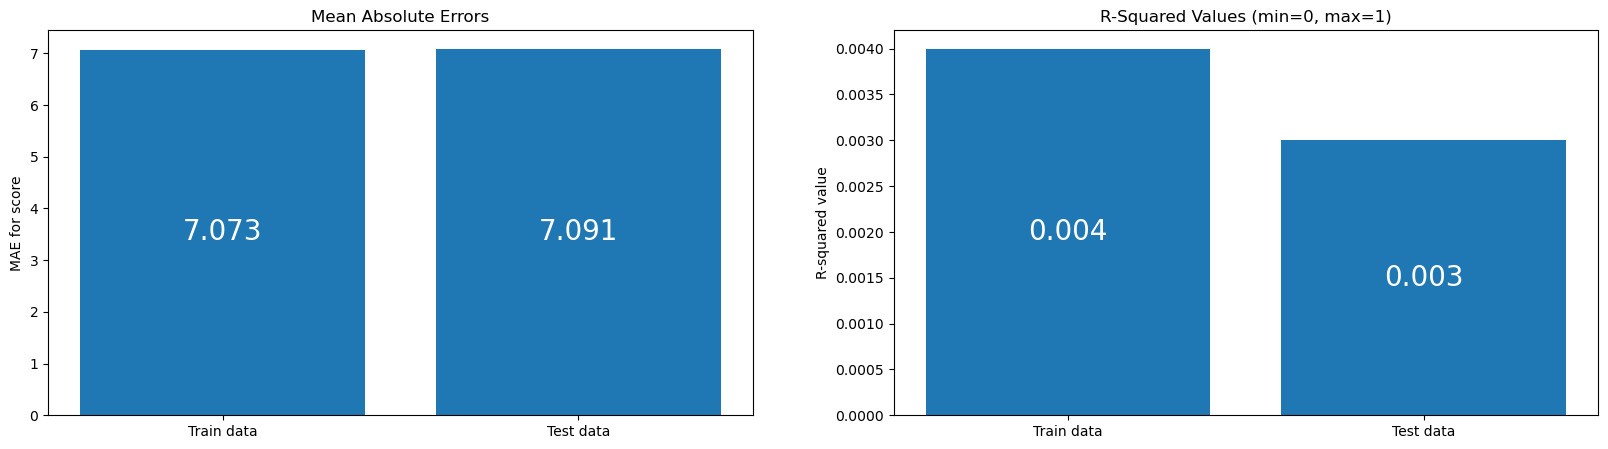

In [15]:
# The first is a barplot of Mean Absolute Errors, for both train and test data.
# The second is a barplot of R-squared values for both train and test data.

plot_error(model1_results, "score")

In [16]:
# The first is a horizontal barplot of the top 20 significant positive words.
# The second is a horizontal barplot of the top 20 significant negative words.
# "Significant" means that the linear regression model thought the word's coefficient
# was significant at the alpha=0.05 level.

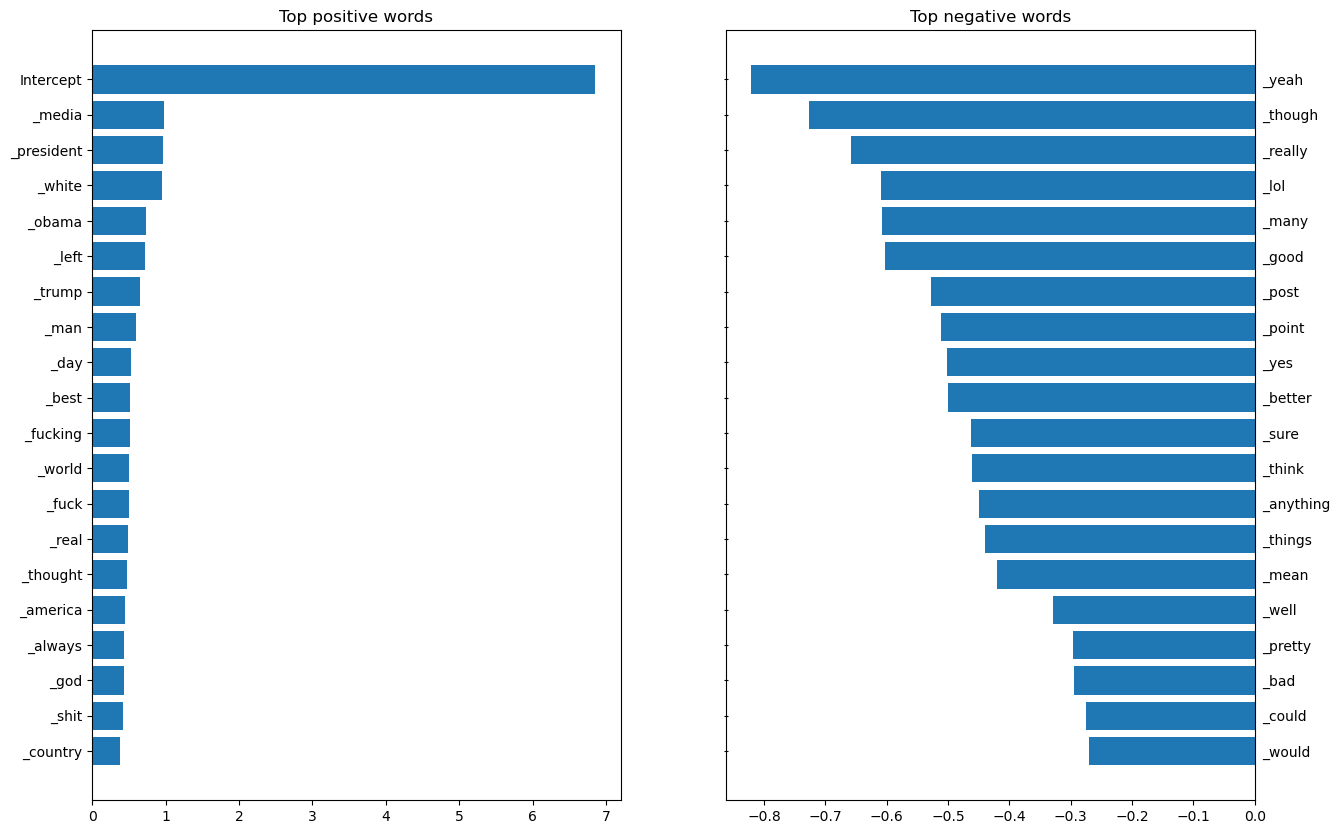

In [17]:
top_words(model1_results)

In [18]:
# The first is a scatterplot of actual values vs. model predictions.
# Since you expect model predictions and actual values to be somewhat similar,
# this scatterplot will resemble an upward diagonal line if the model is good.
# It's a good visual aid for someone looking to judge a model's performance.

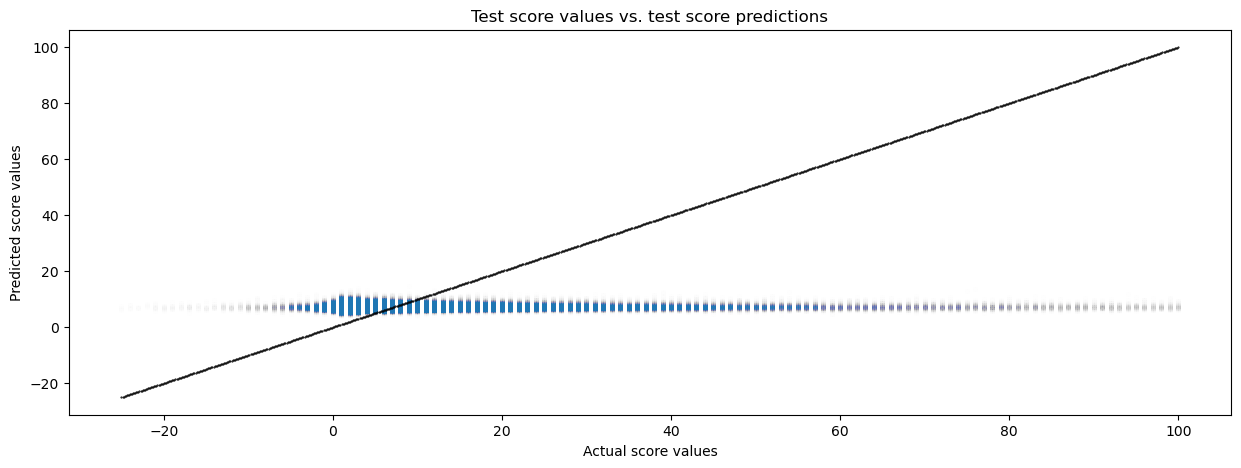

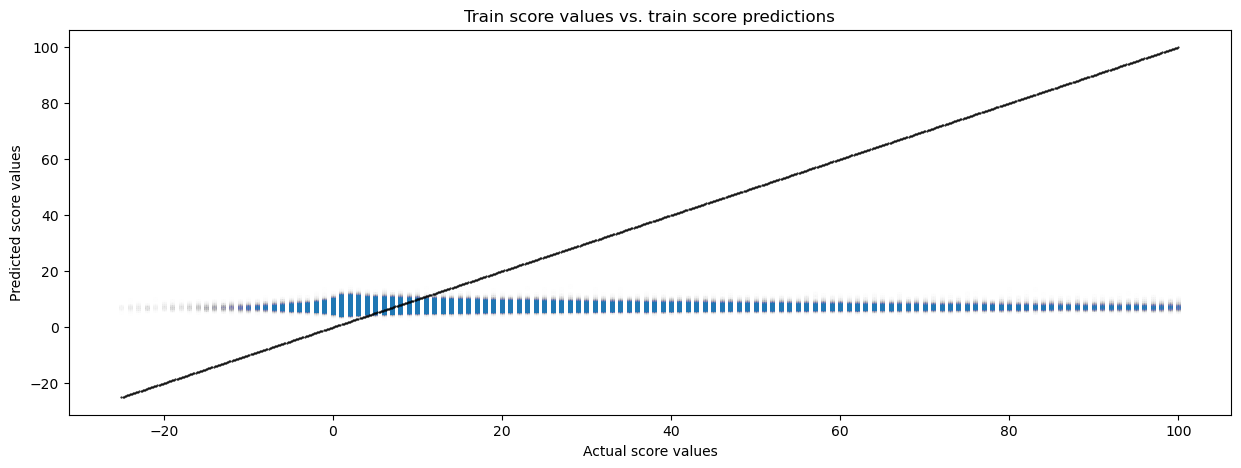

In [19]:
actual_predicted_scatterplot(model1_results, "score")

In [20]:
# The first is an aggregated time series for actual values and predicted values for train data
# The second is an aggregated time series for actual values and predicted values for test data
# "Aggregated" means that every point is average value over the course of an entire month.
# For example, every point on the blue "predicted" line on the left-hand time series is the average
# value over the course of an entire month in the train predictions.

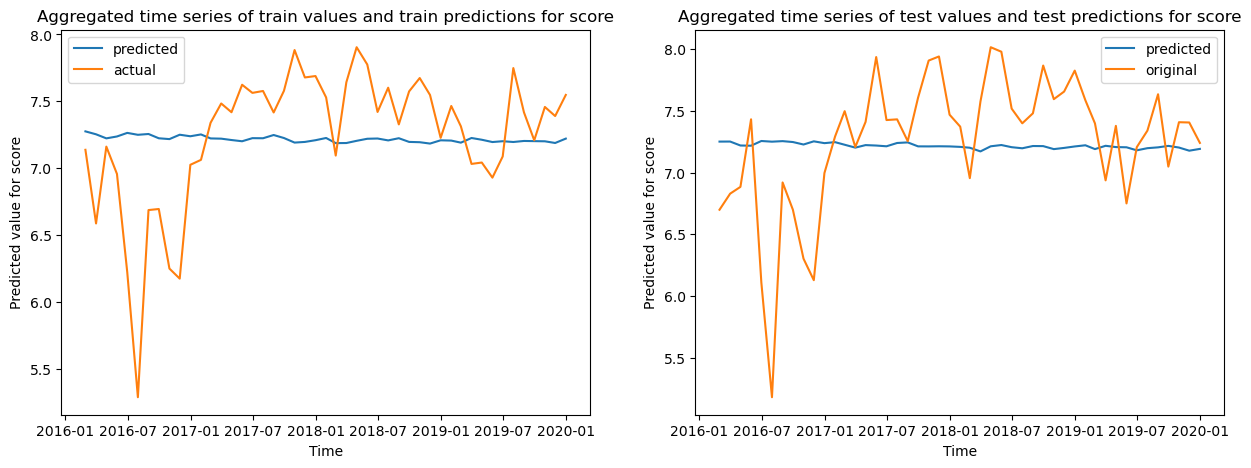

In [21]:
actual_predicted_timeseries(model1_results, "score")

In [22]:
# The top two visualizations are histograms of model residuals
# (the magnitude of error for each model prediction). These histograms
# should be approximately normally distributed, since linear regression assumes it.
# The bottom two visualizations are scatterplots of residuals over time. It should be 
# relatively uniform.

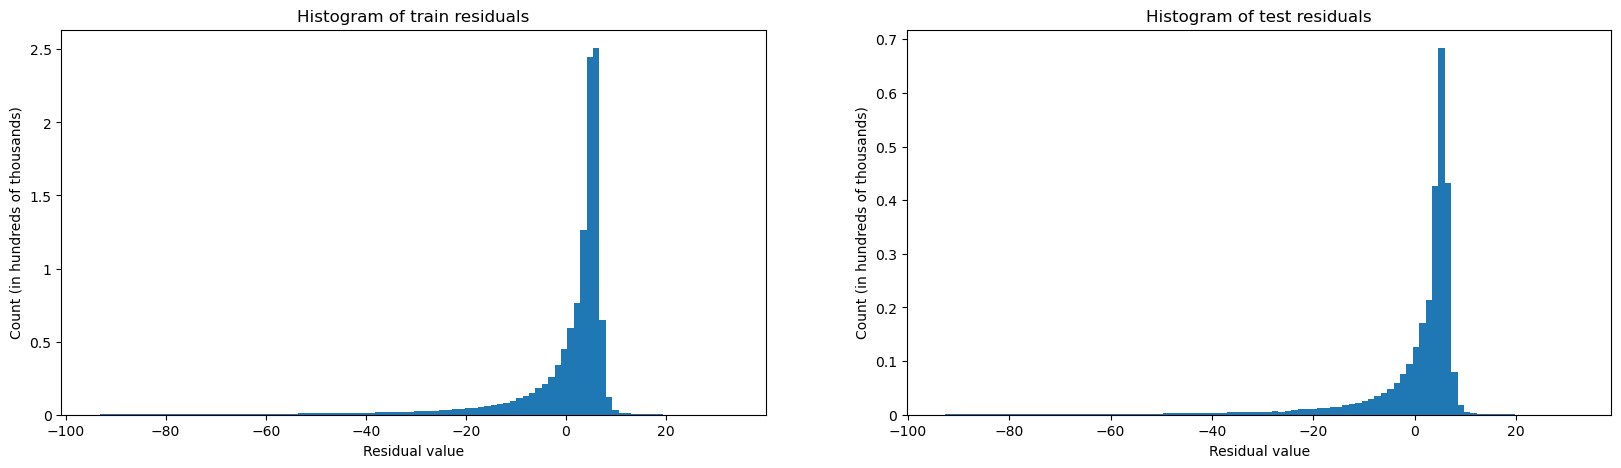

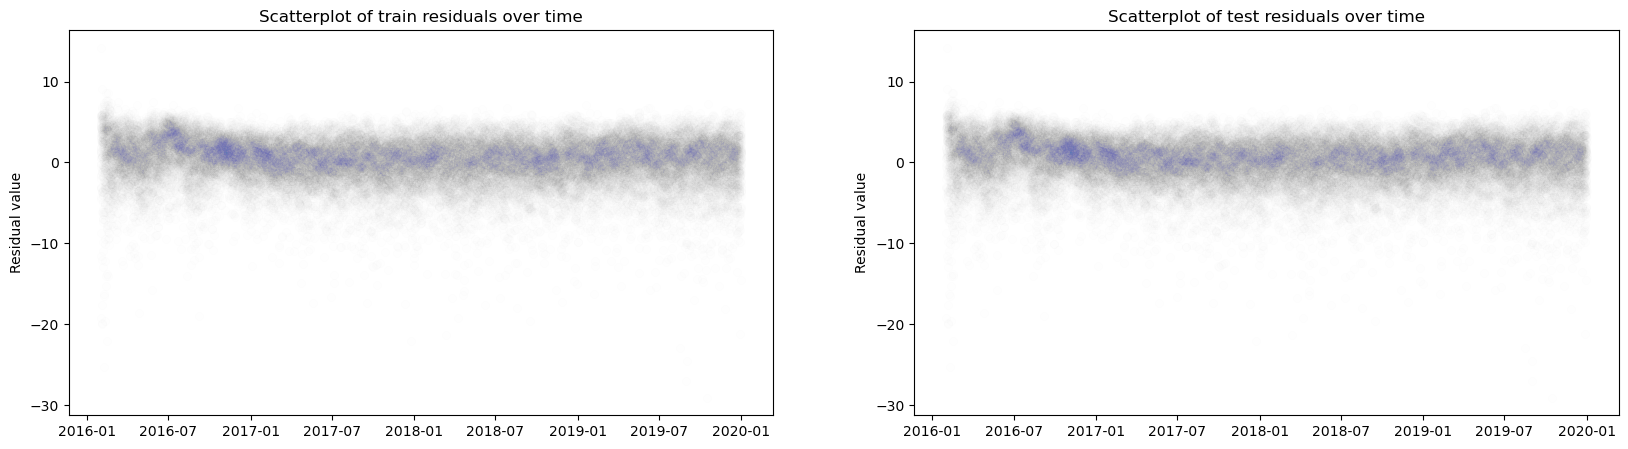

In [23]:
residuals(model1_results)

## Bigrams

In [24]:
X = bigram_features
y = scores[scores.index.isin(X.index)]

In [25]:
model2_results = linear_model(X, y)

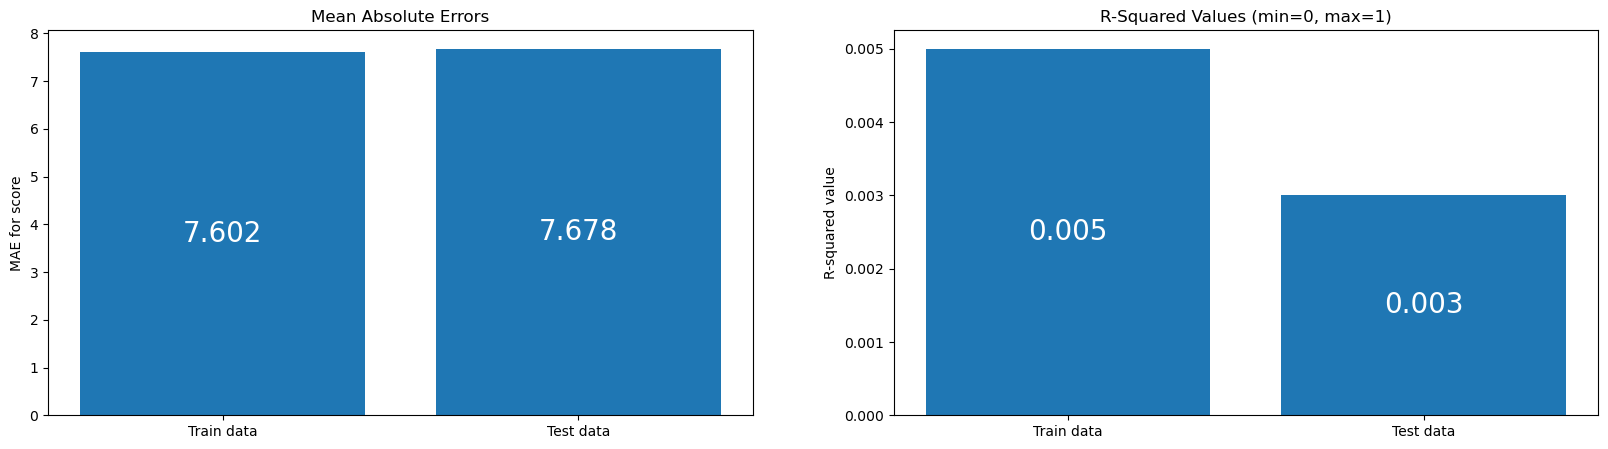

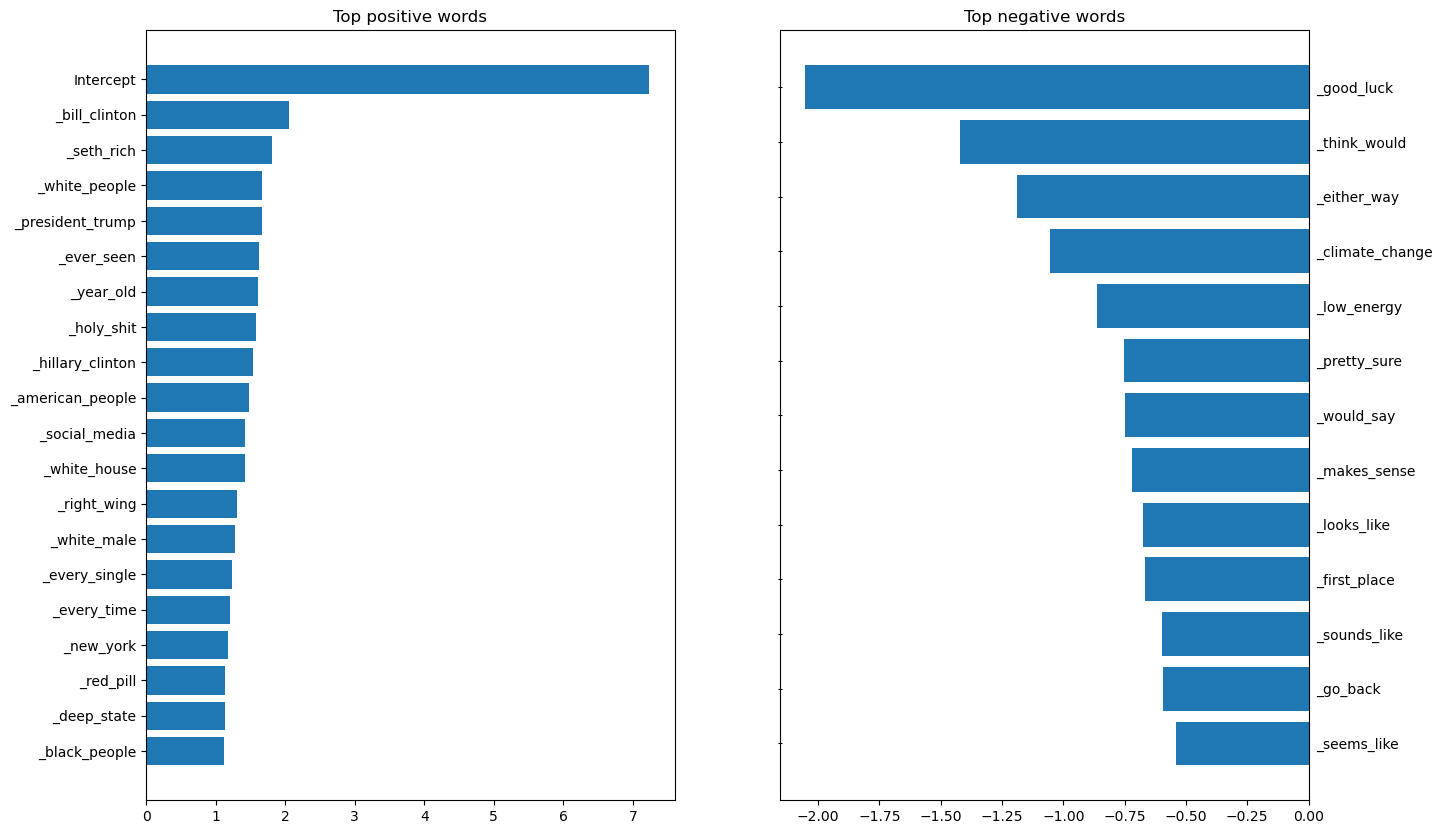

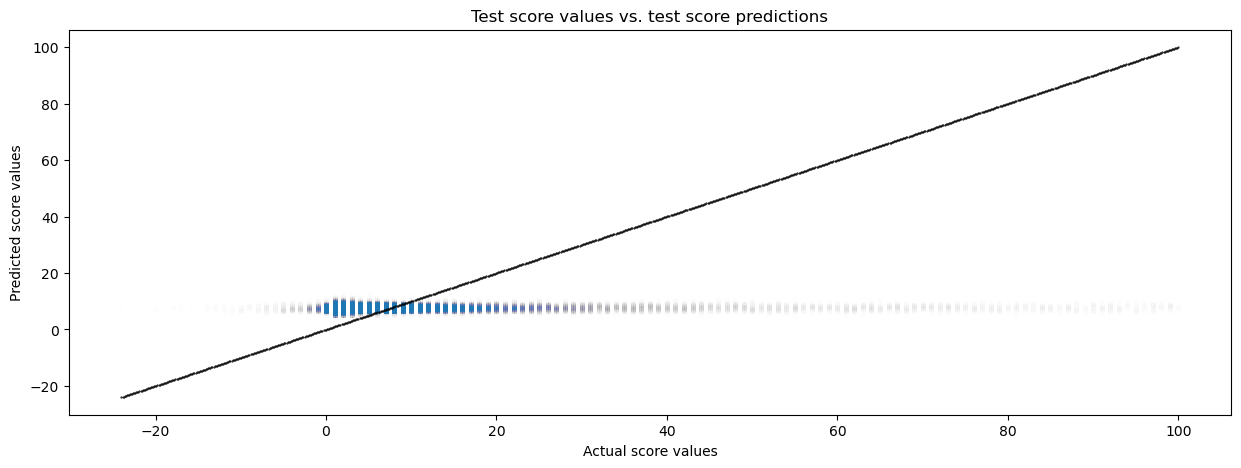

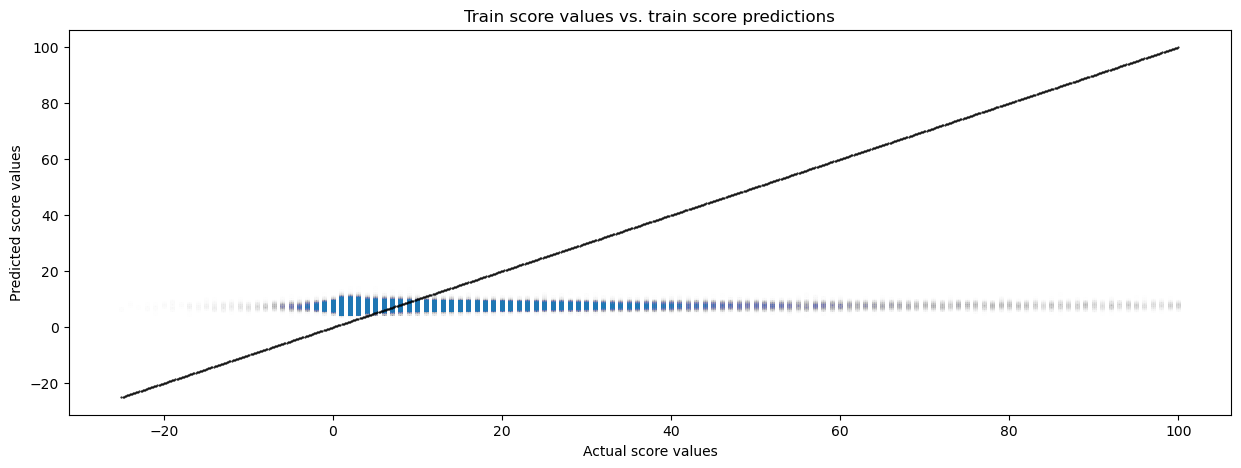

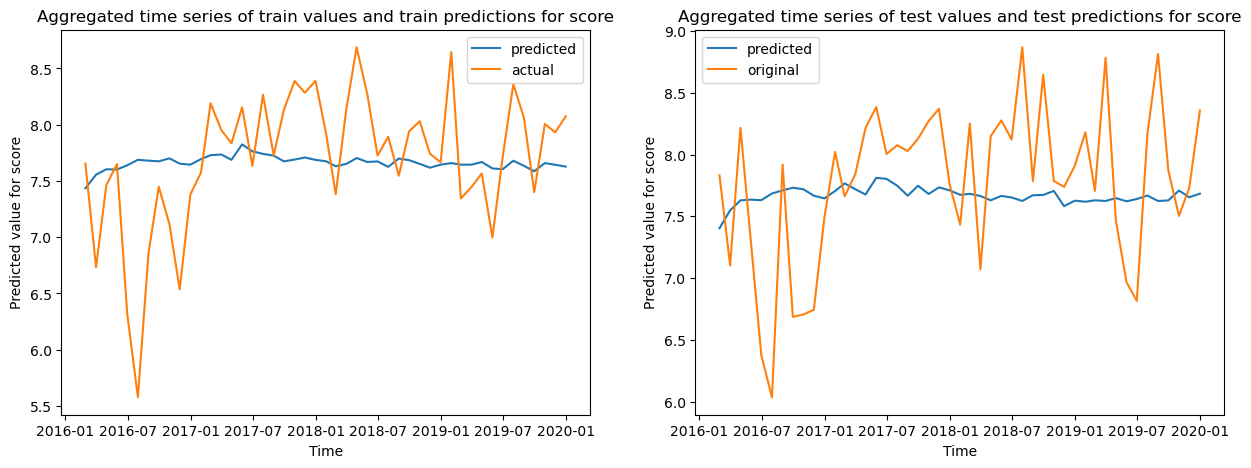

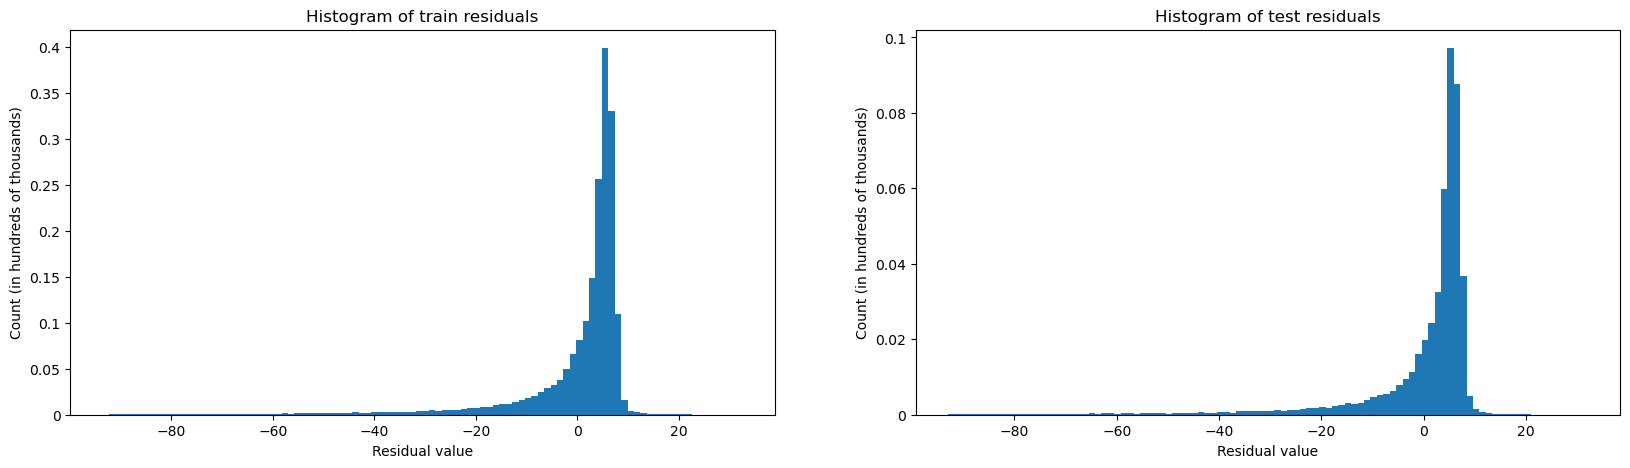

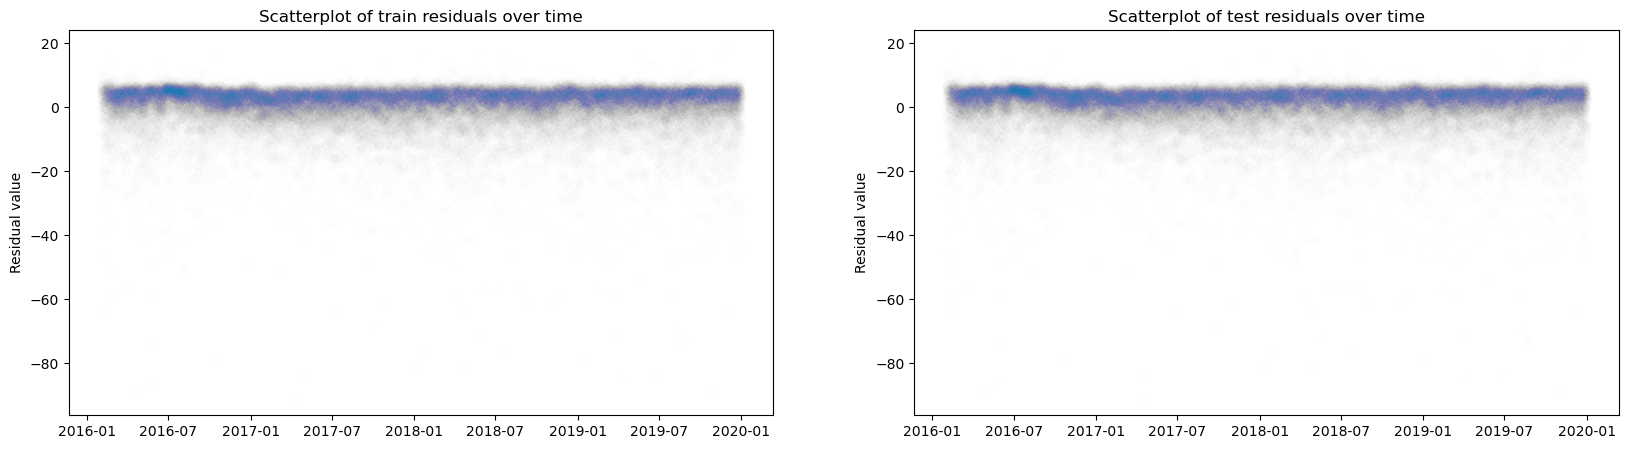

In [26]:
analyze_model(model2_results, line=True, target="score")

## Trigrams

In [27]:
X = trigram_features
y = scores[scores.index.isin(X.index)]

In [28]:
model3_results = linear_model(X, y)

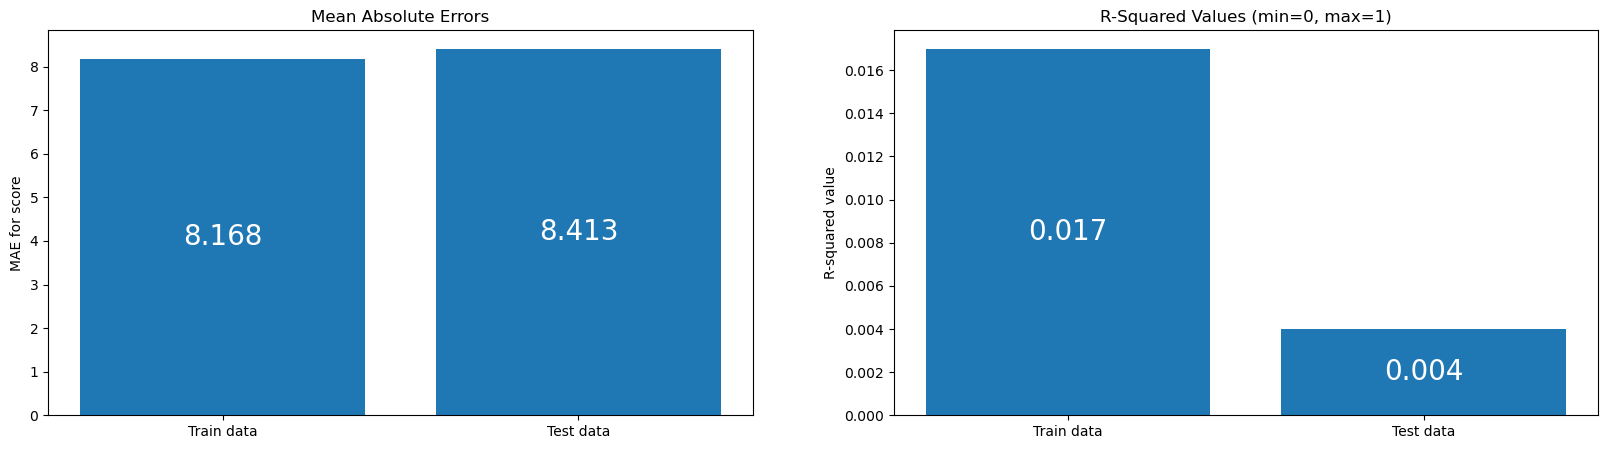

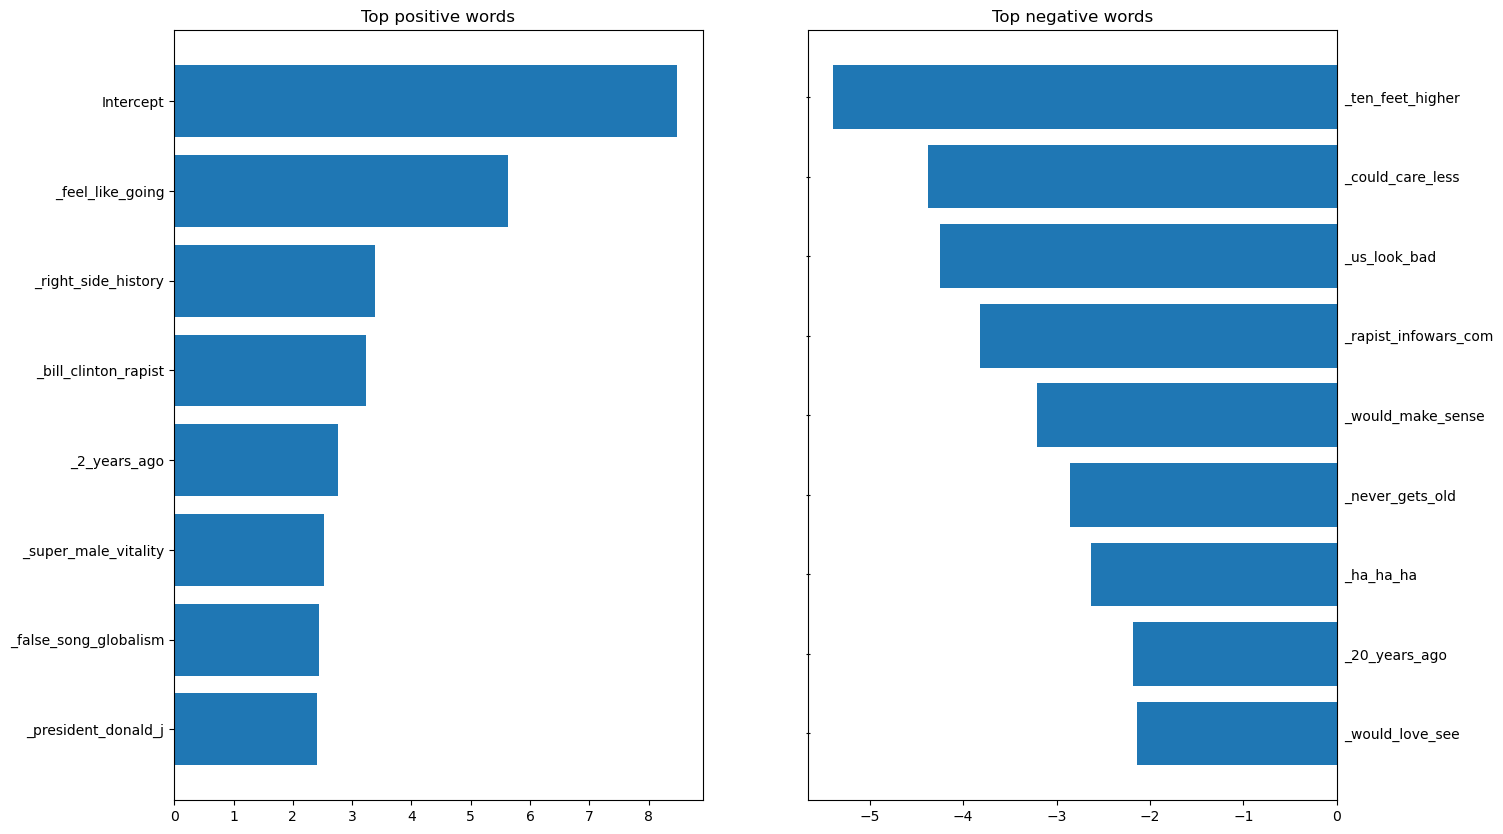

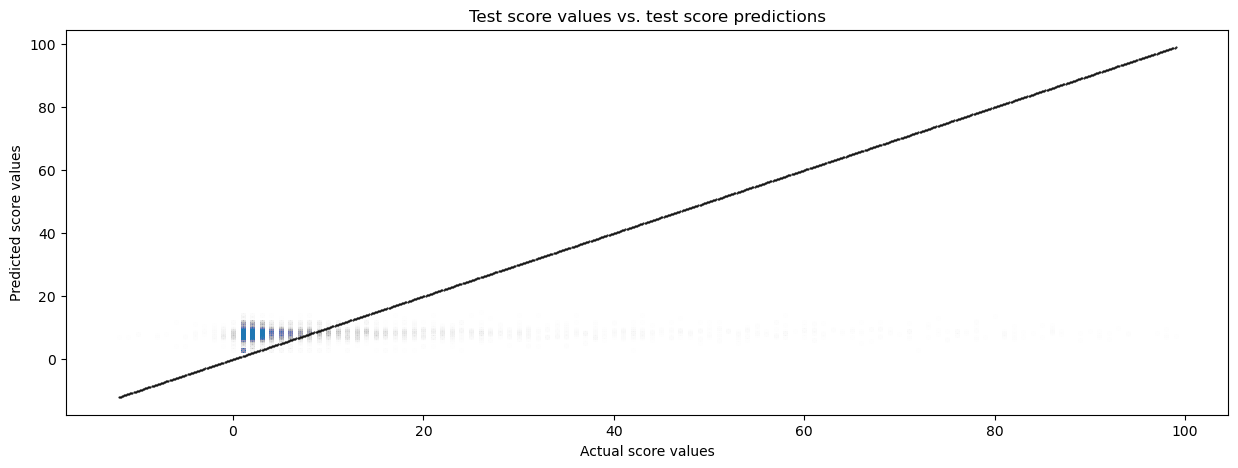

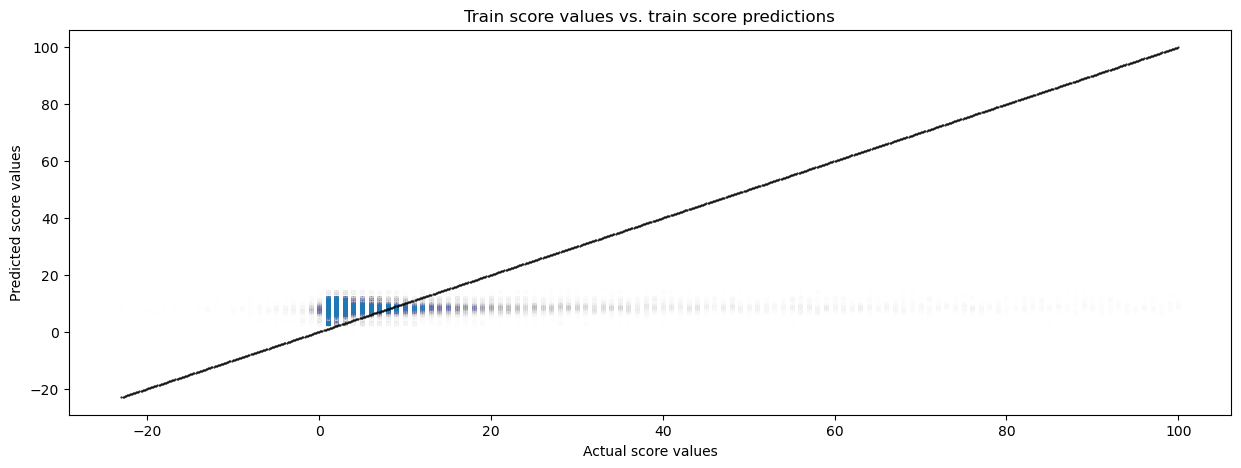

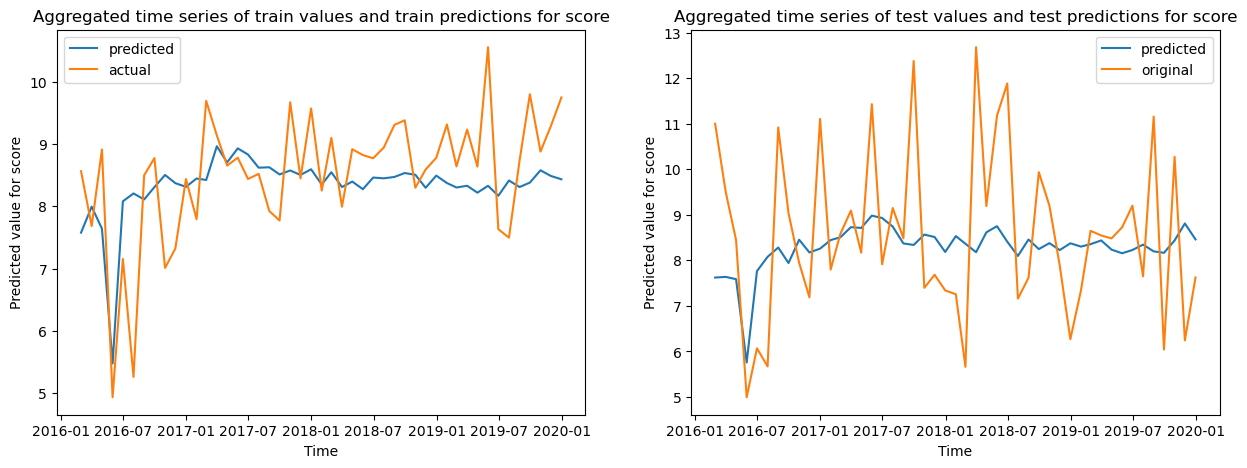

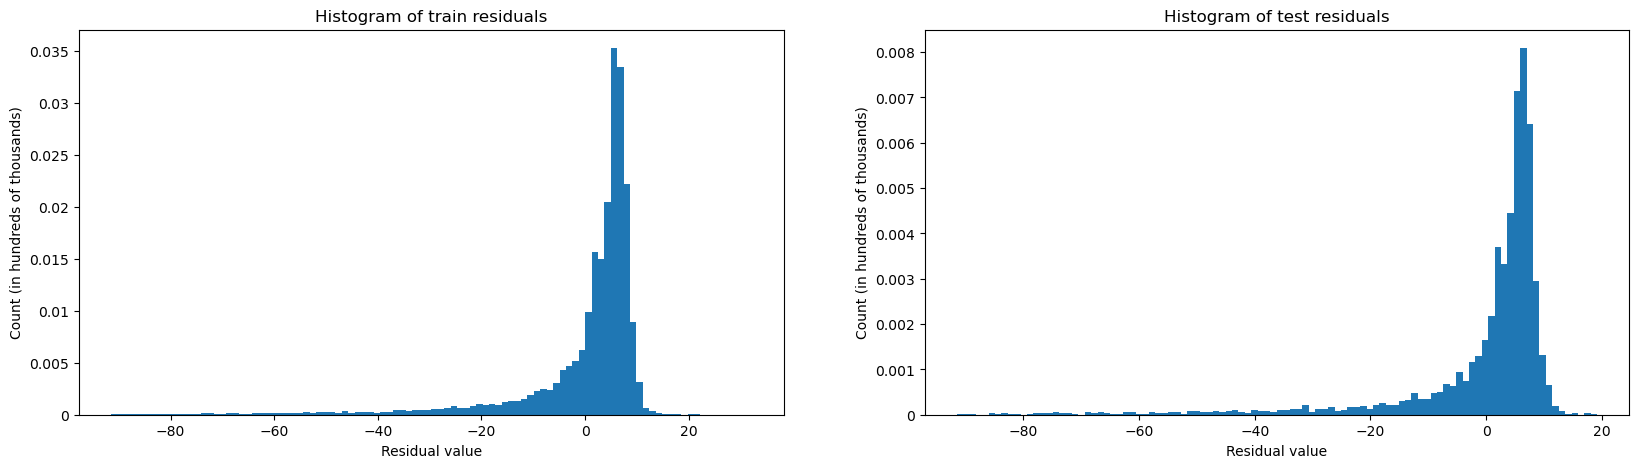

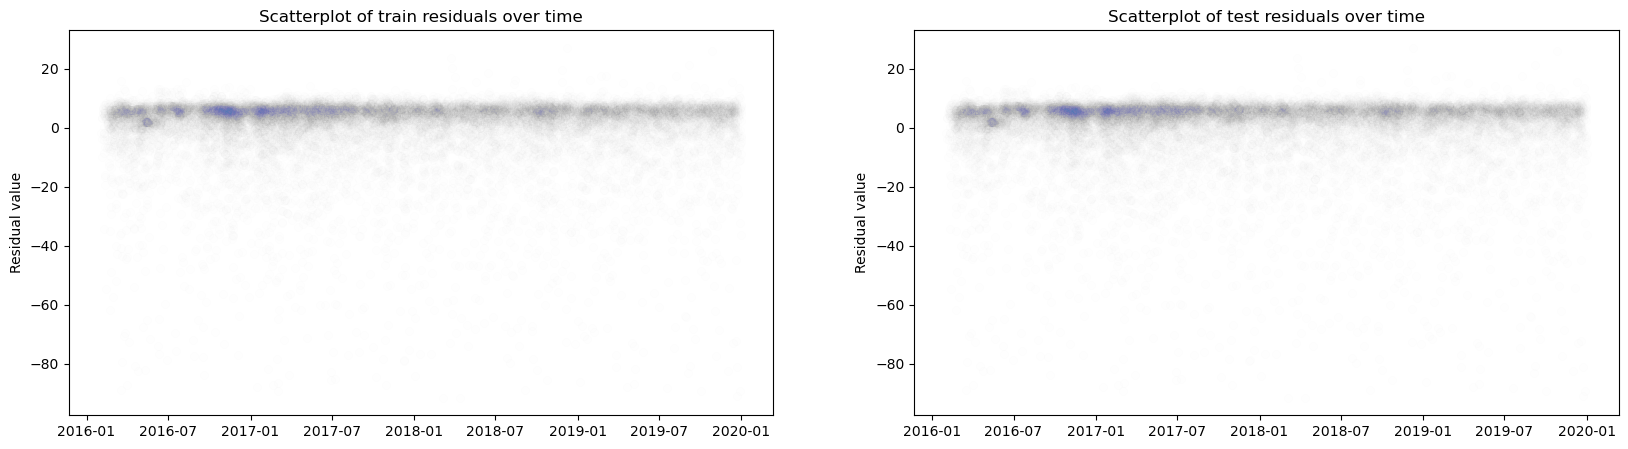

In [29]:
analyze_model(model3_results, line=True, target="score")

# Second Model: Linear Regression, VADER as target

## Unigrams

In [30]:
X = unigram_features
y = vader[vader.index.isin(X.index)]

In [31]:
model4_results = linear_model(X, y)

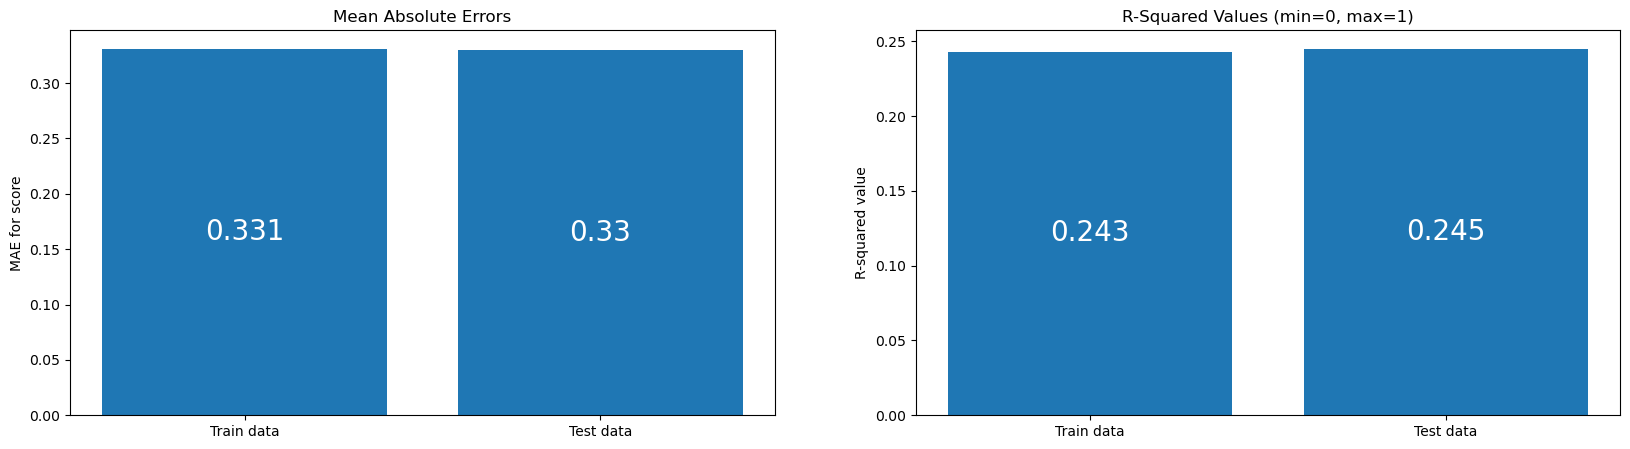

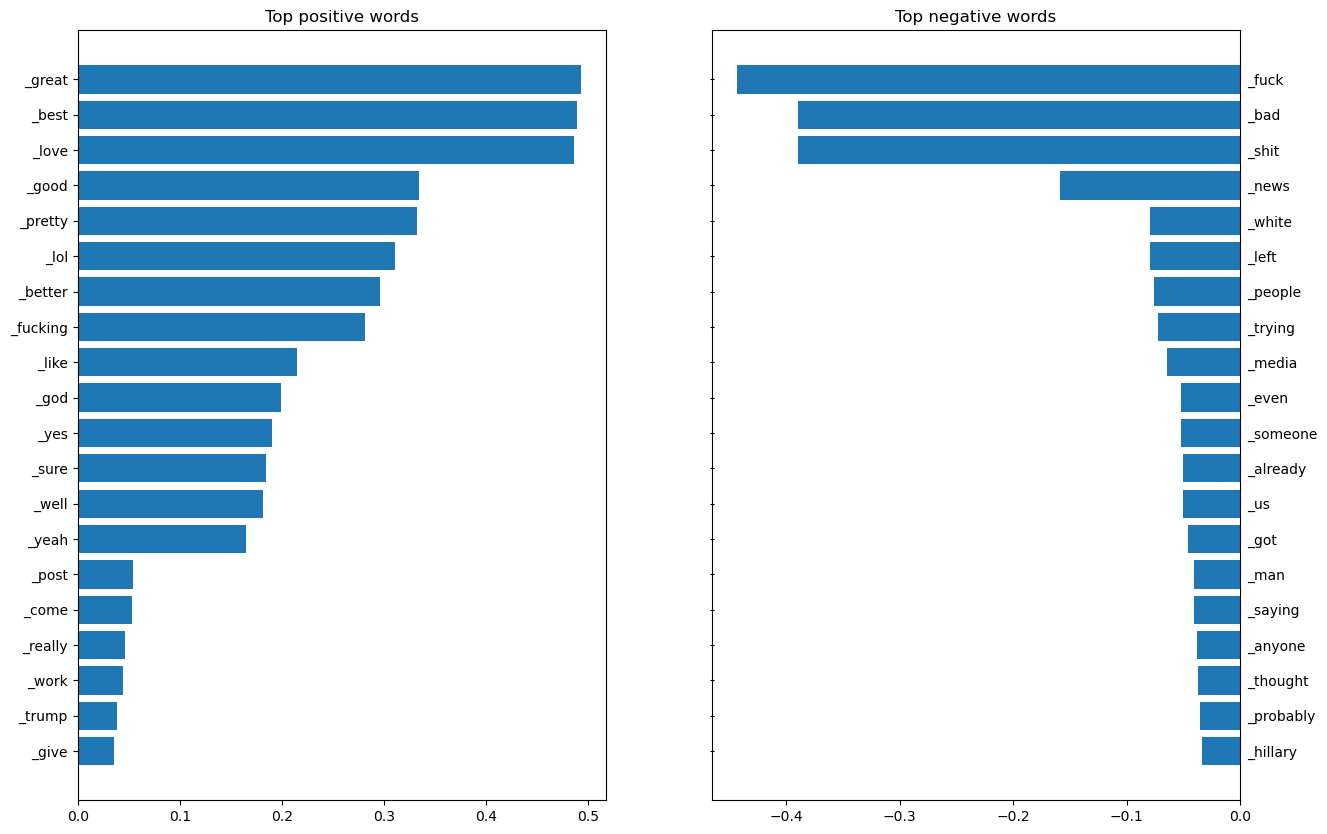

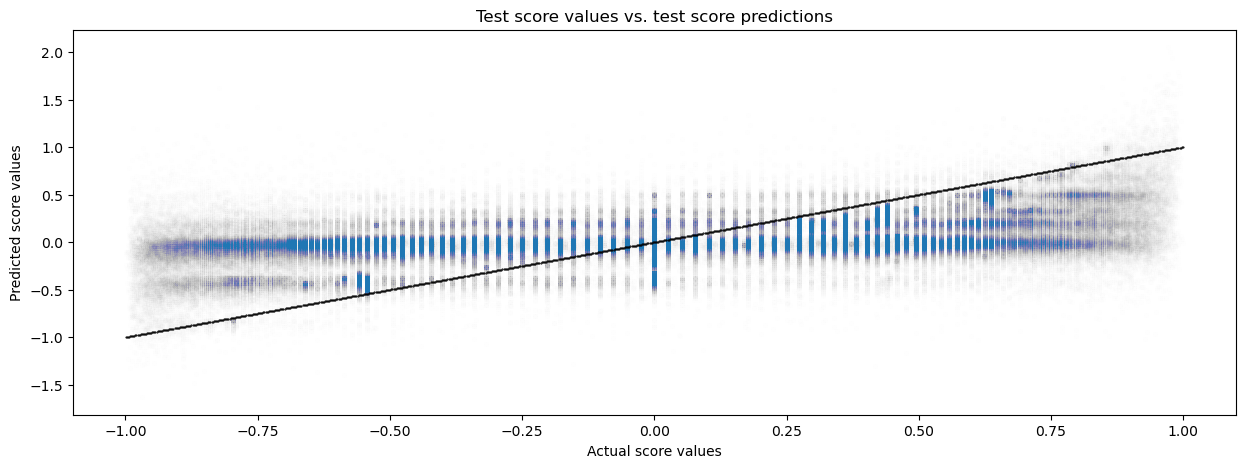

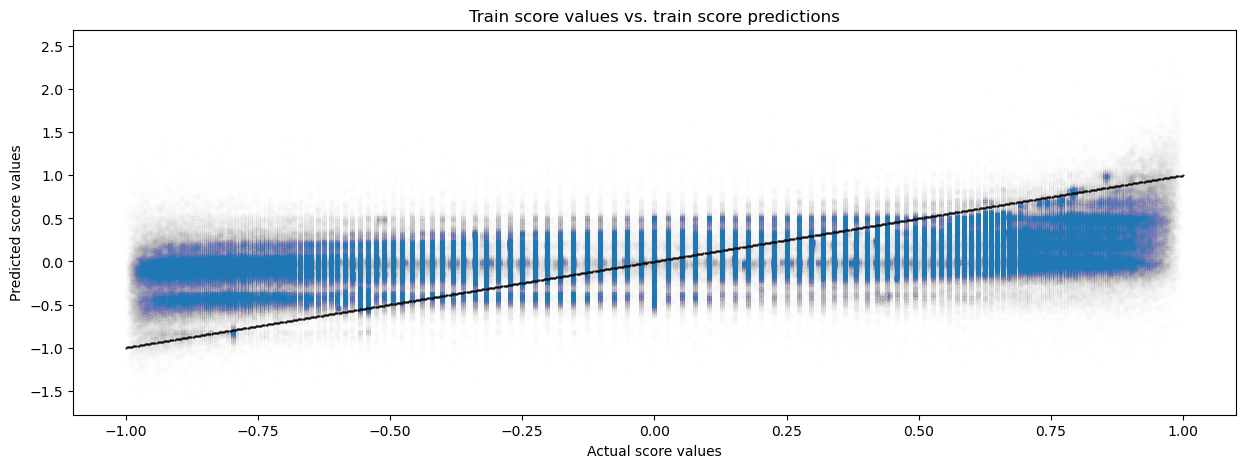

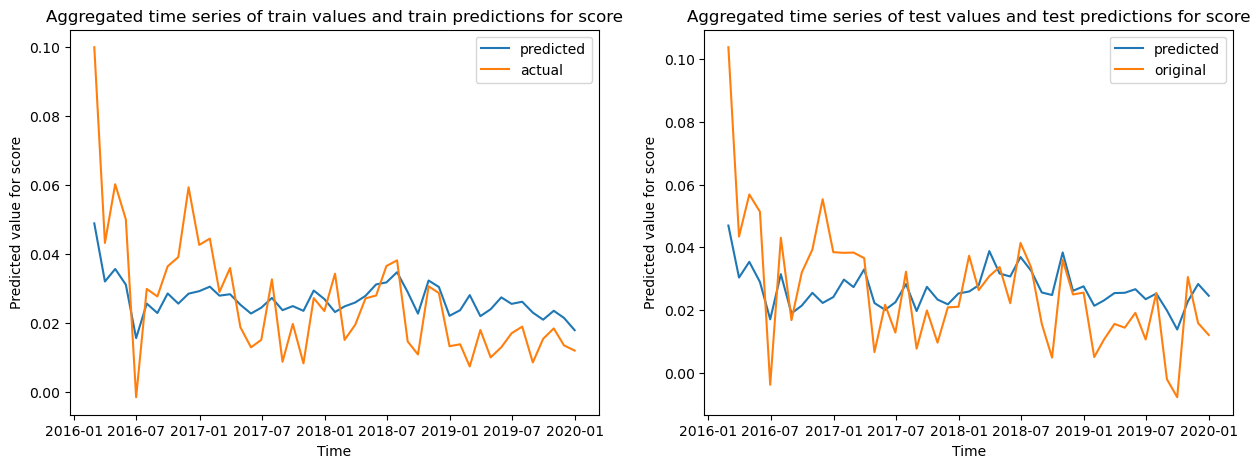

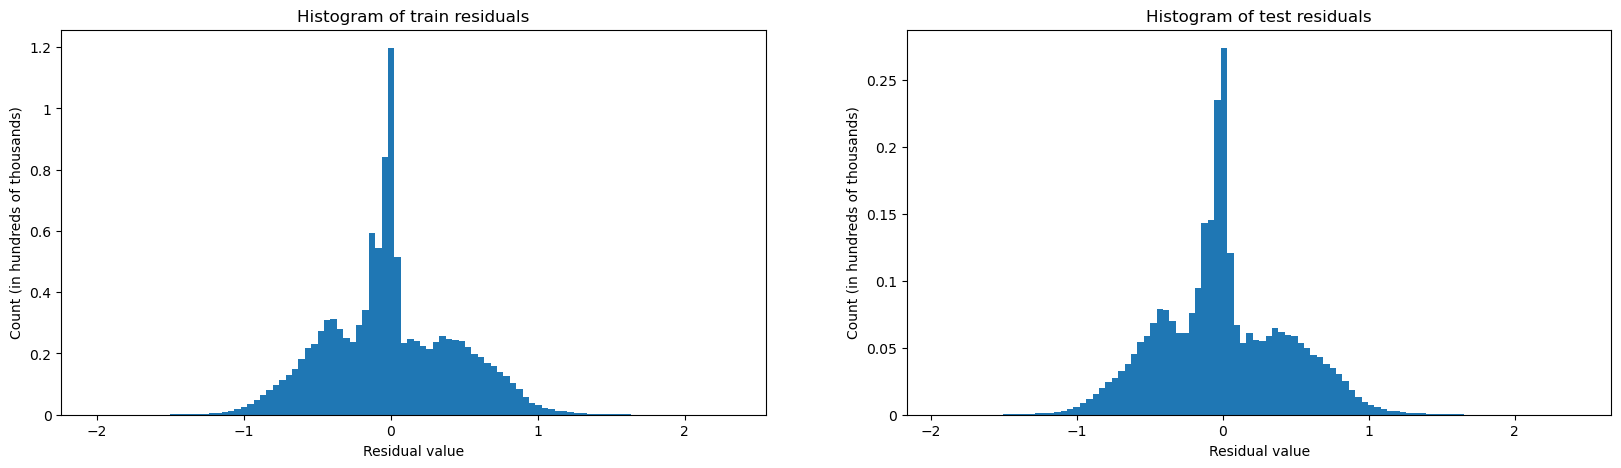

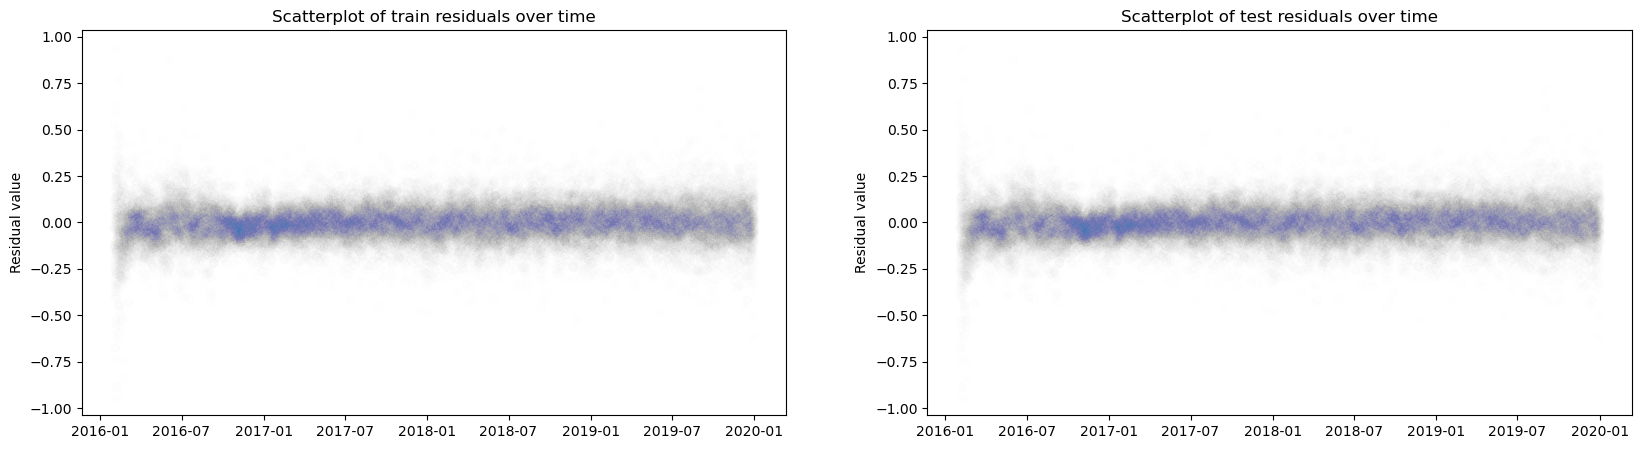

In [32]:
analyze_model(model4_results, line=True, target="score")

## Bigrams

In [33]:
X = bigram_features
y = vader[vader.index.isin(X.index)]

In [34]:
model5_results = linear_model(X, y)

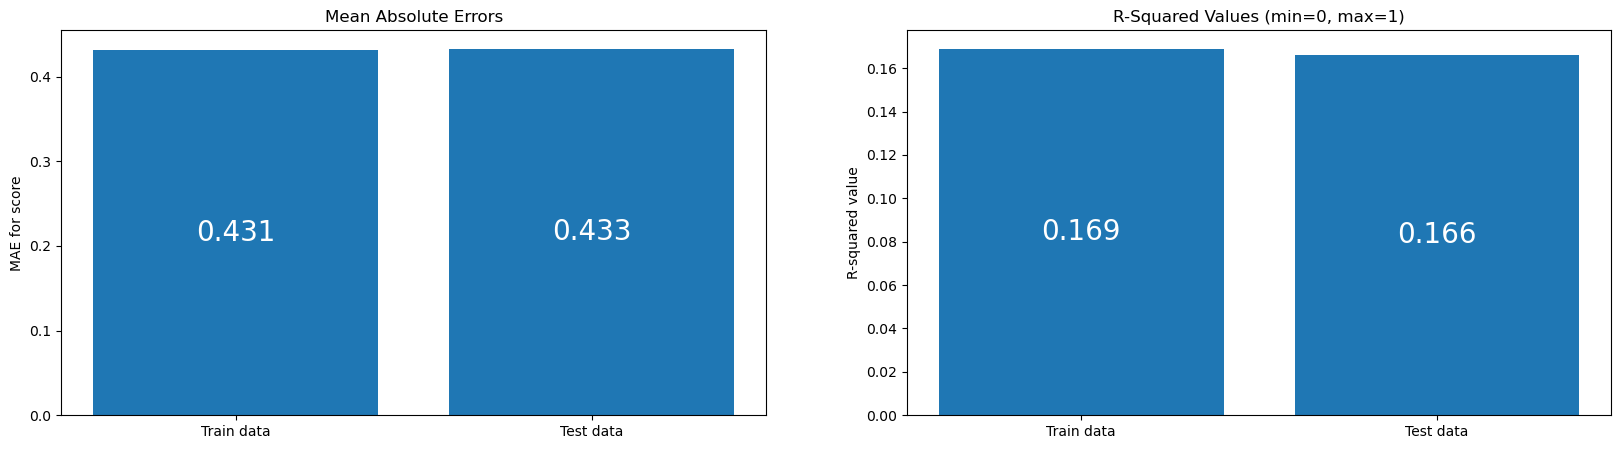

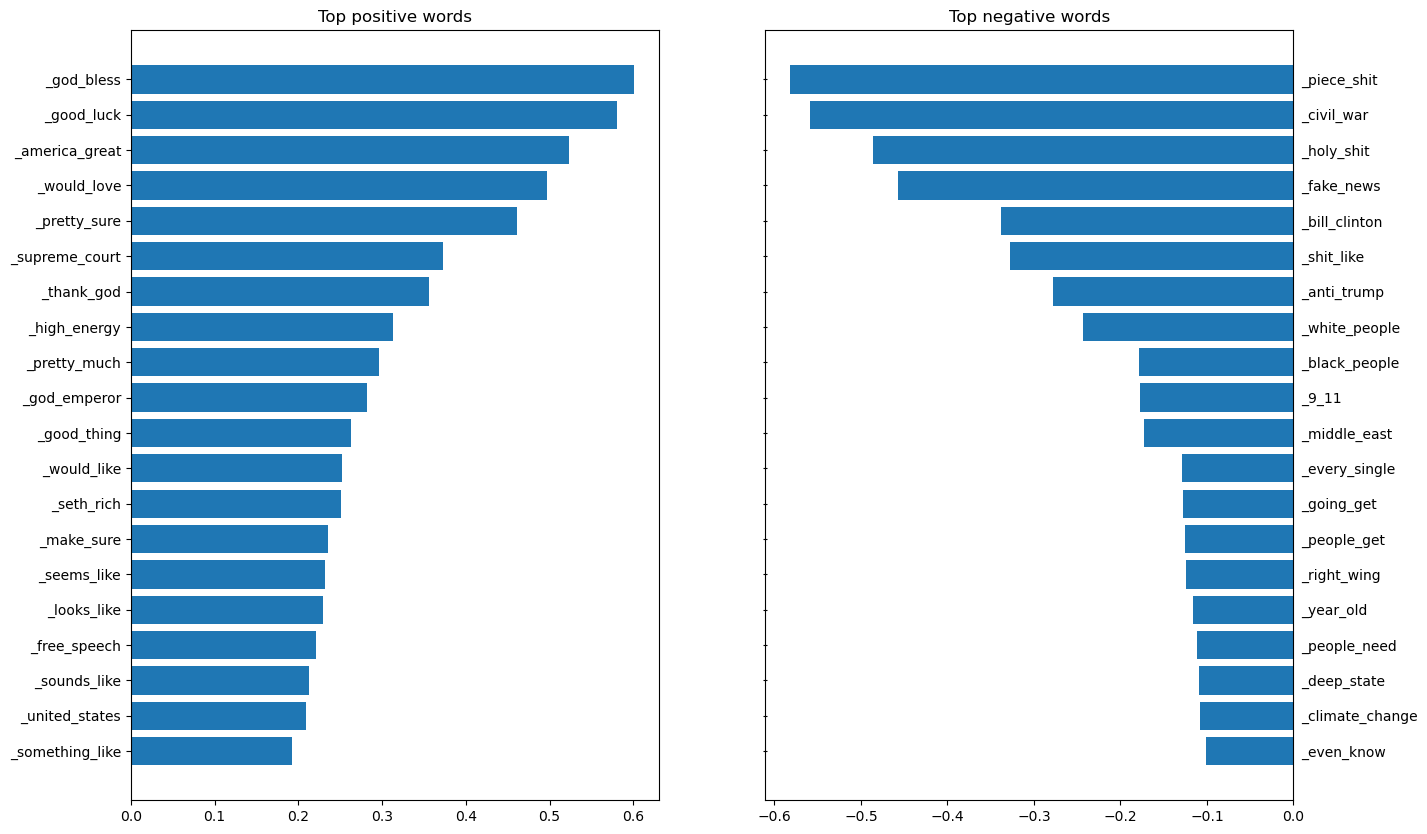

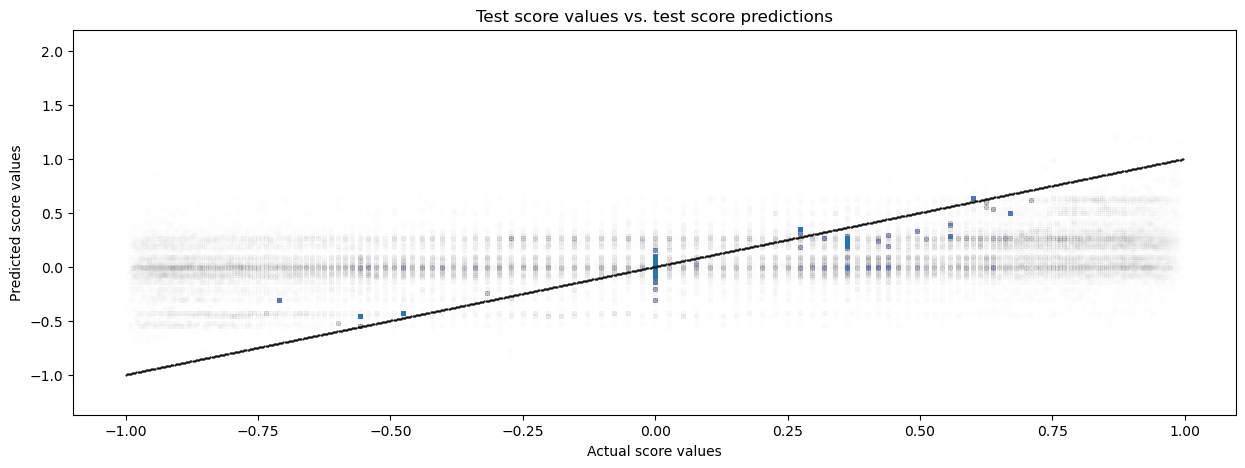

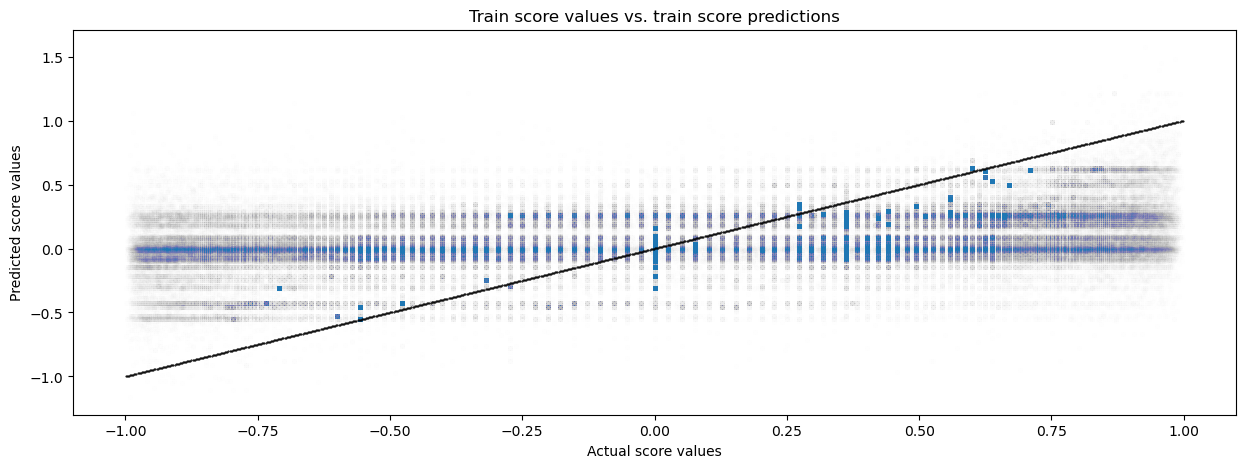

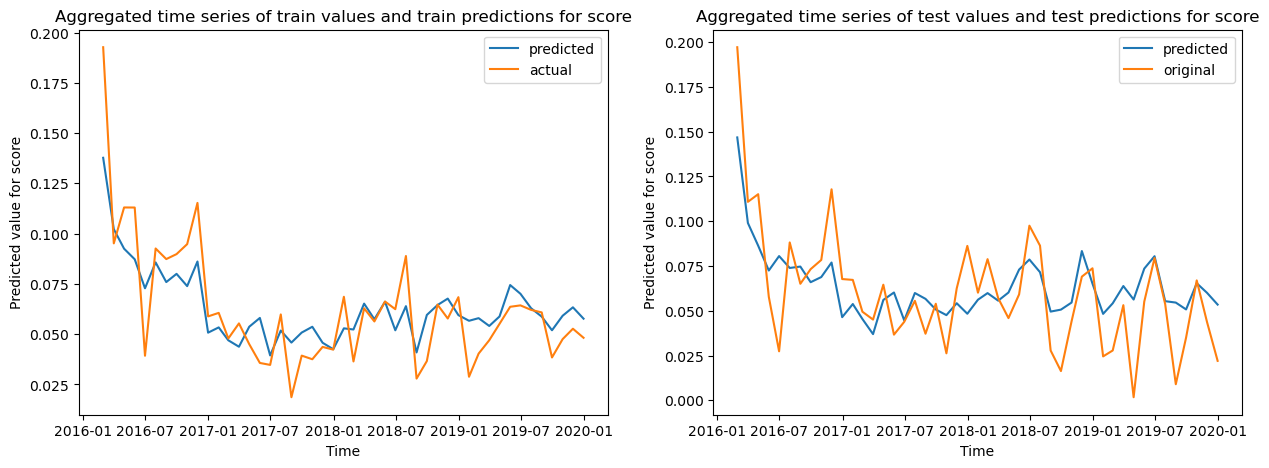

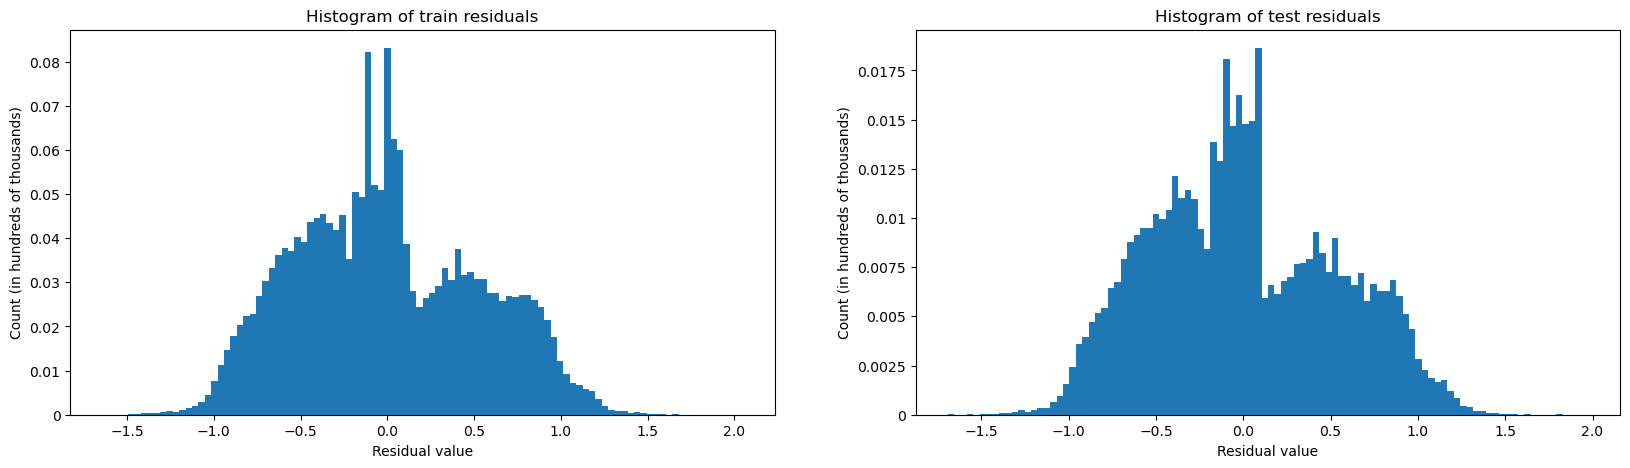

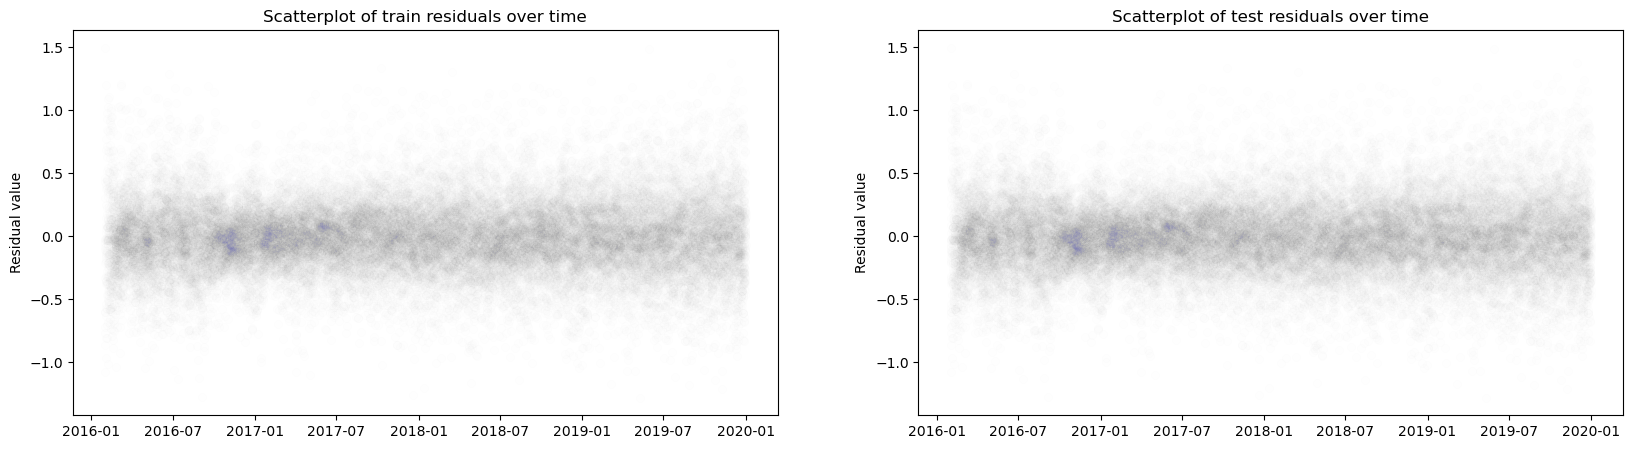

In [35]:
analyze_model(model5_results, line=True, target="score")

## Trigrams

In [36]:
X = trigram_features
y = vader[vader.index.isin(X.index)]

In [37]:
model6_results = linear_model(X, y)

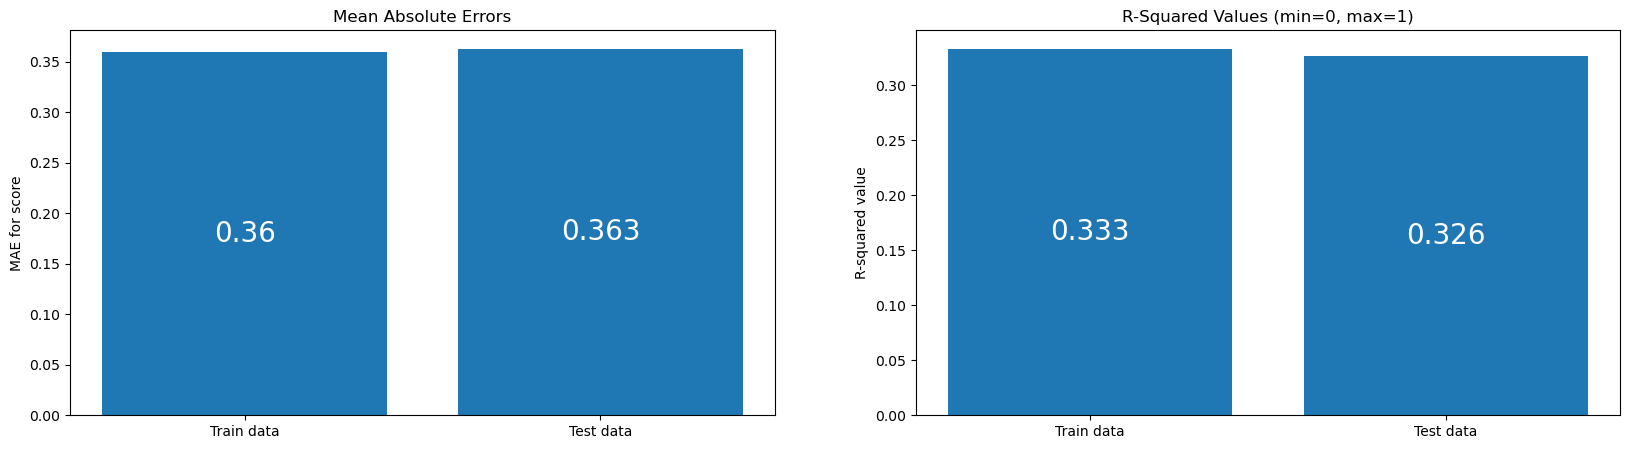

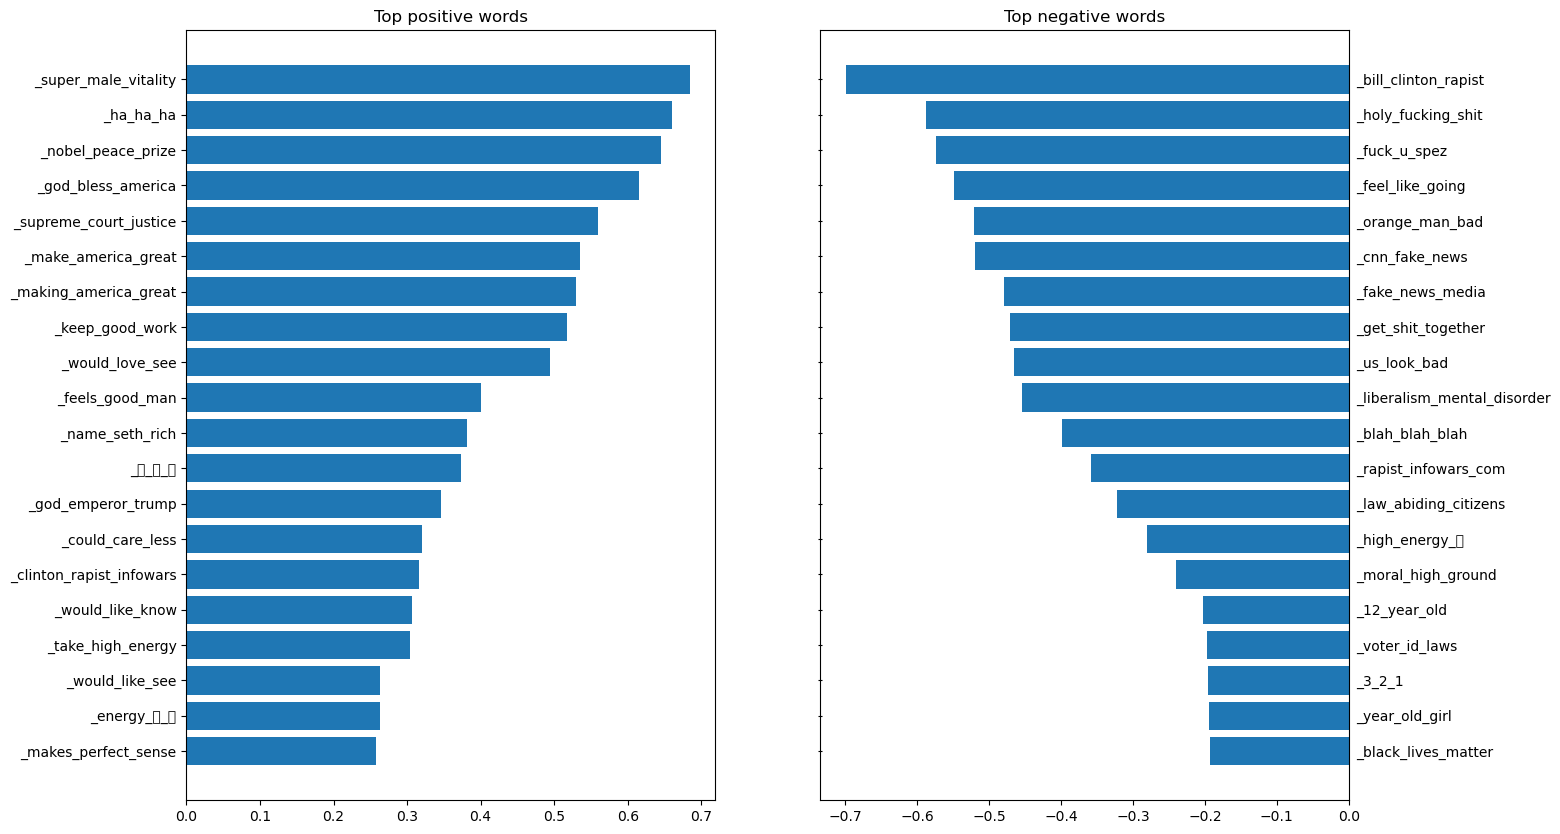

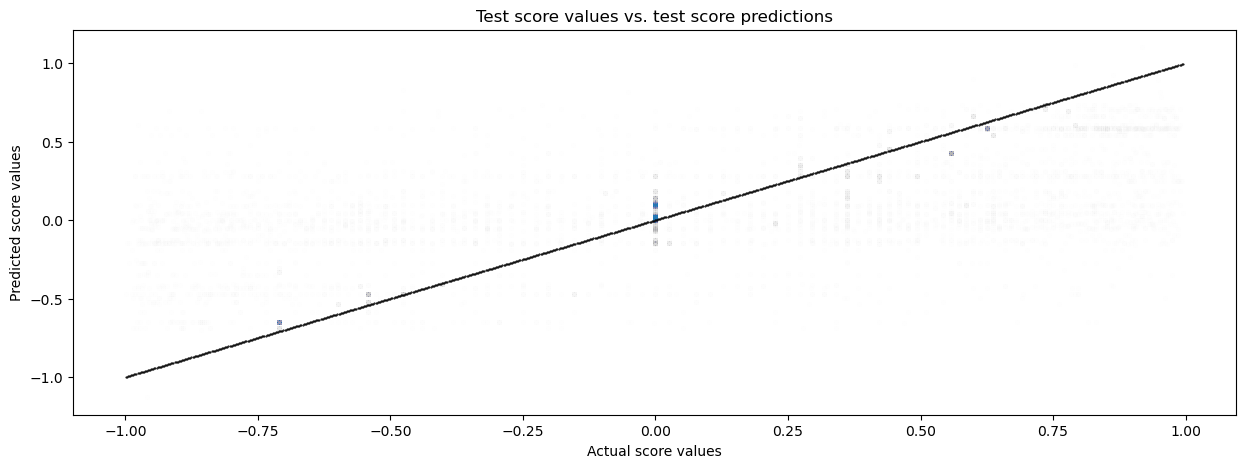

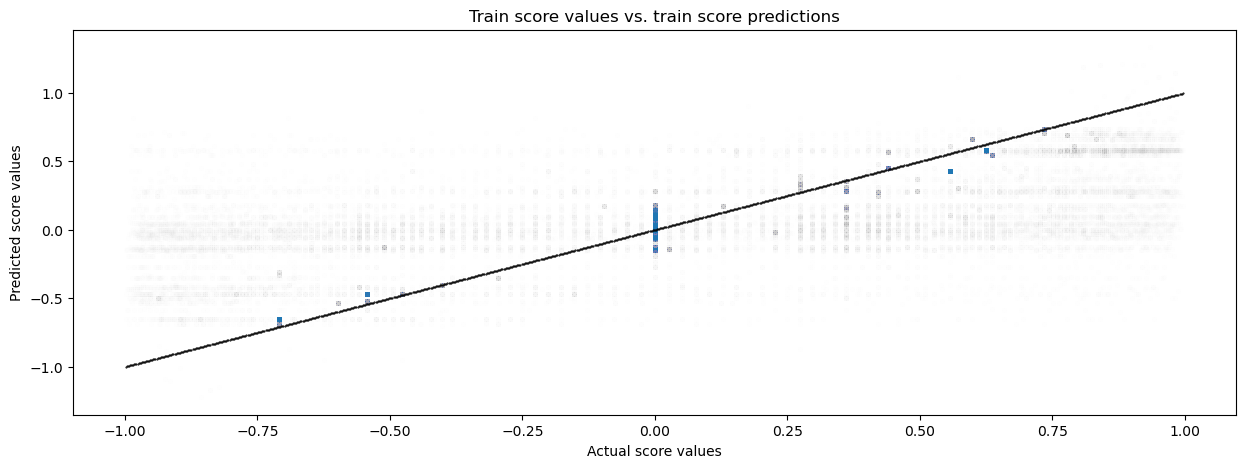

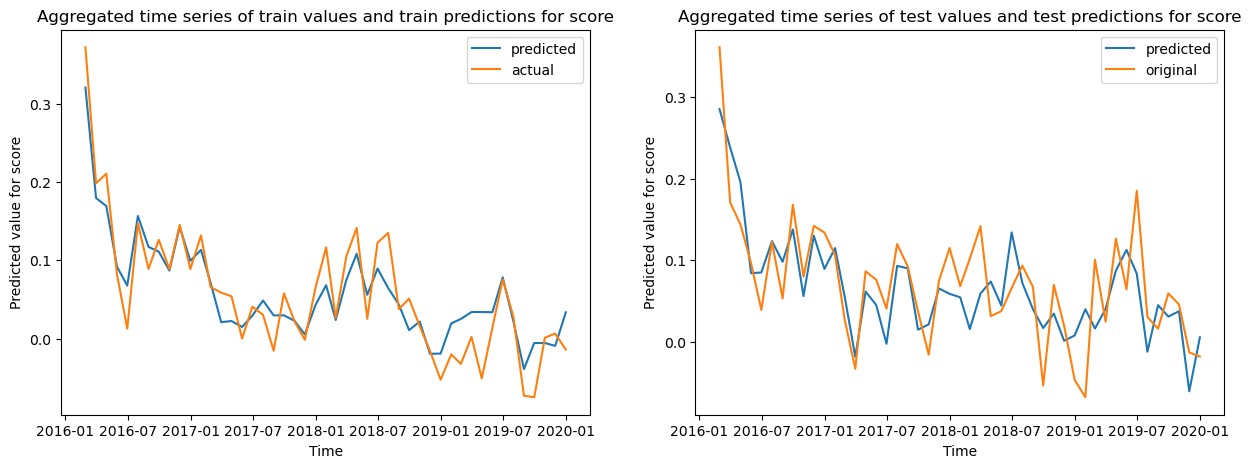

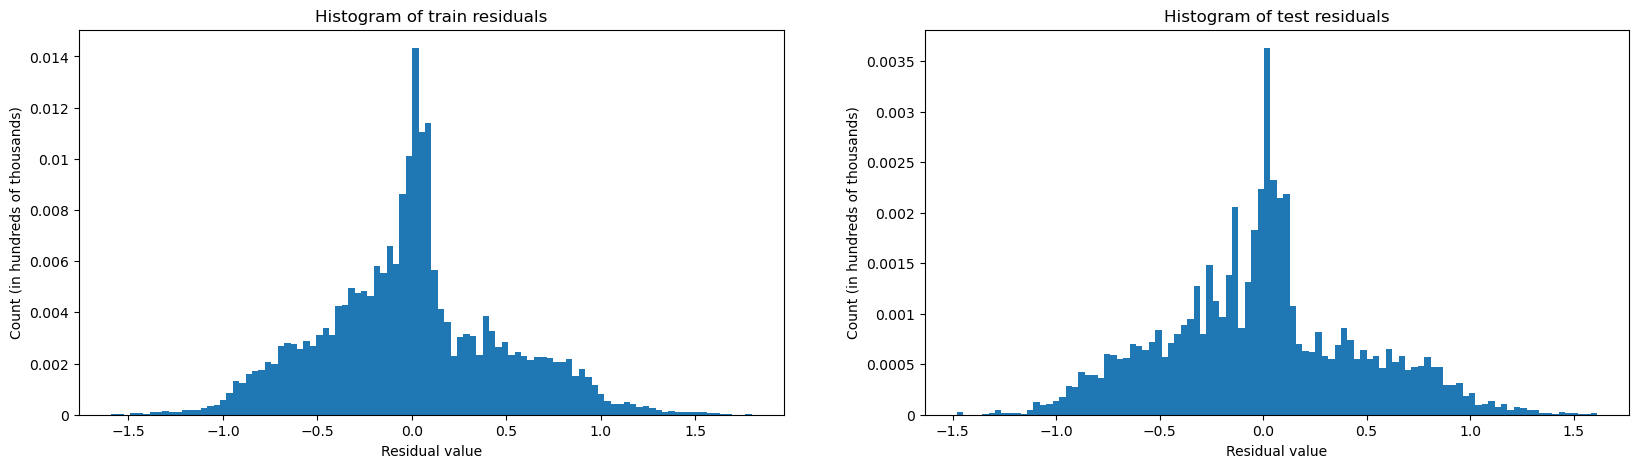

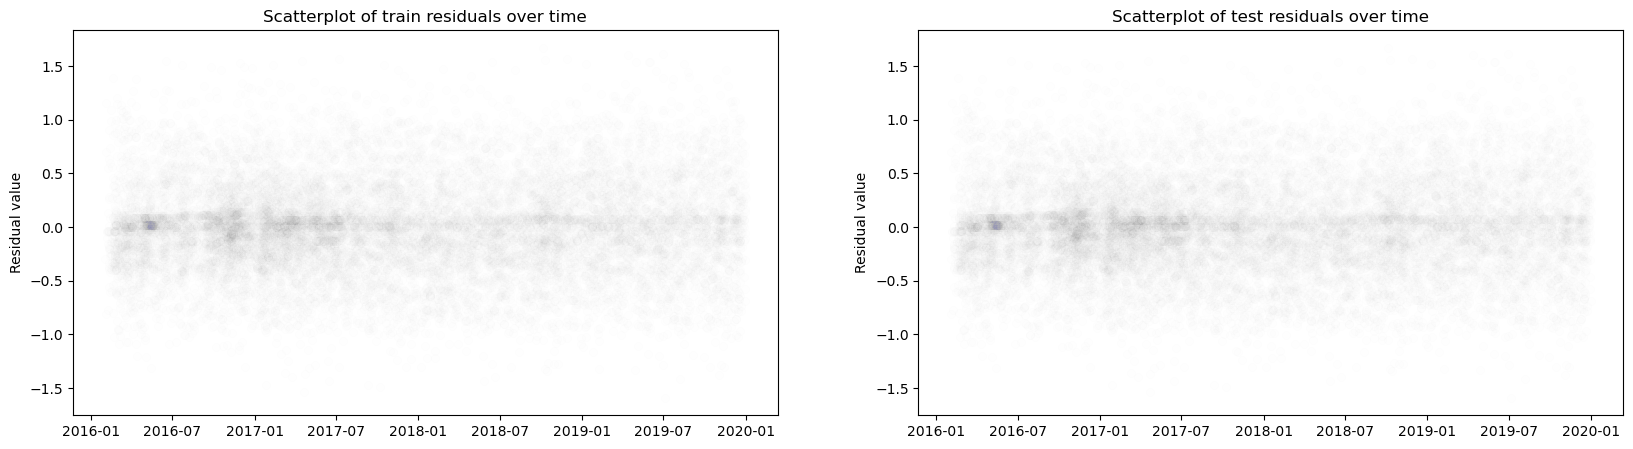

In [38]:
analyze_model(model6_results, line=True, target="score")

# Third Model: Linear Regression, VADER as target, neutral scores removed

The distribution of sentiment is saturated with neutral posts. If we remove these, does it help model accuracy?

<Axes: >

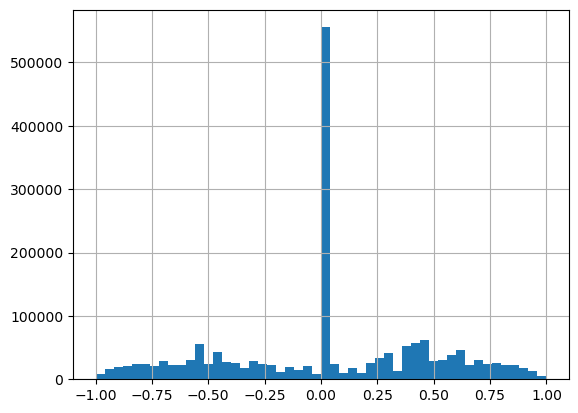

In [39]:
vader.hist(bins=50)

<Axes: >

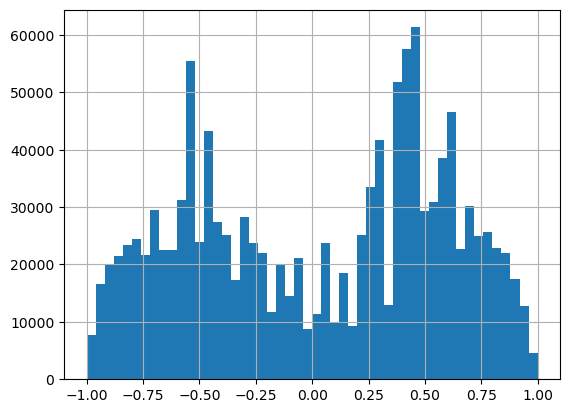

In [40]:
vader[vader!=0].hist(bins=50)

## Unigrams

In [41]:
y = vader[(vader.index.isin(unigram_features.index)) & (vader!=0)]
X = unigram_features[unigram_features.index.isin(y.index)]

In [42]:
model7_results = linear_model(X, y)

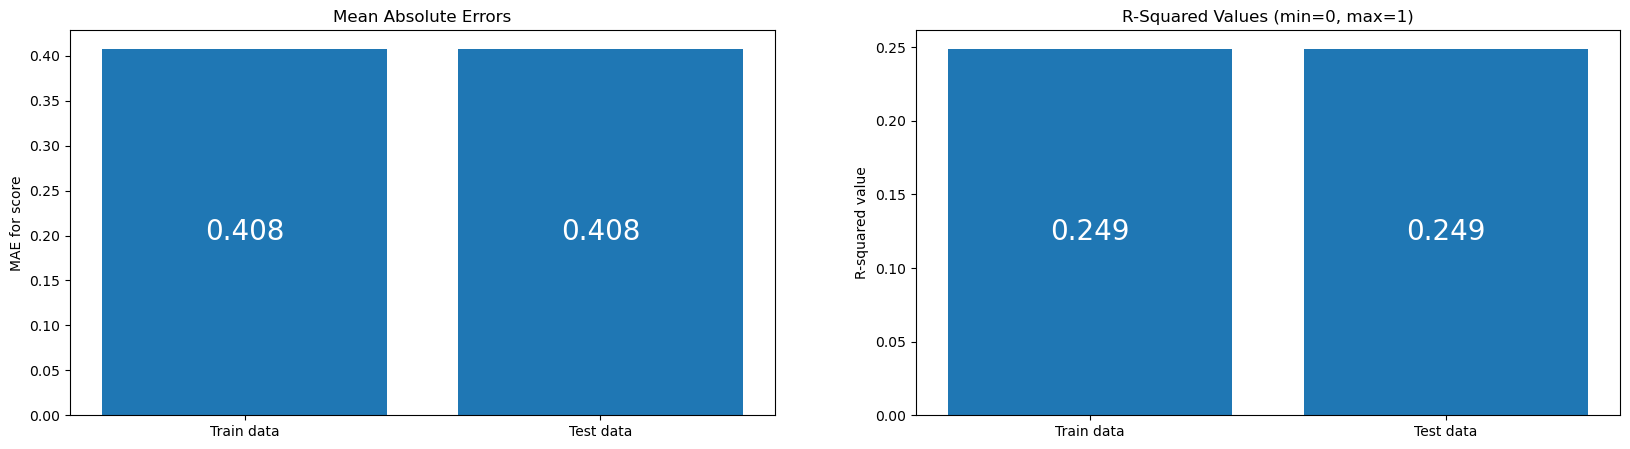

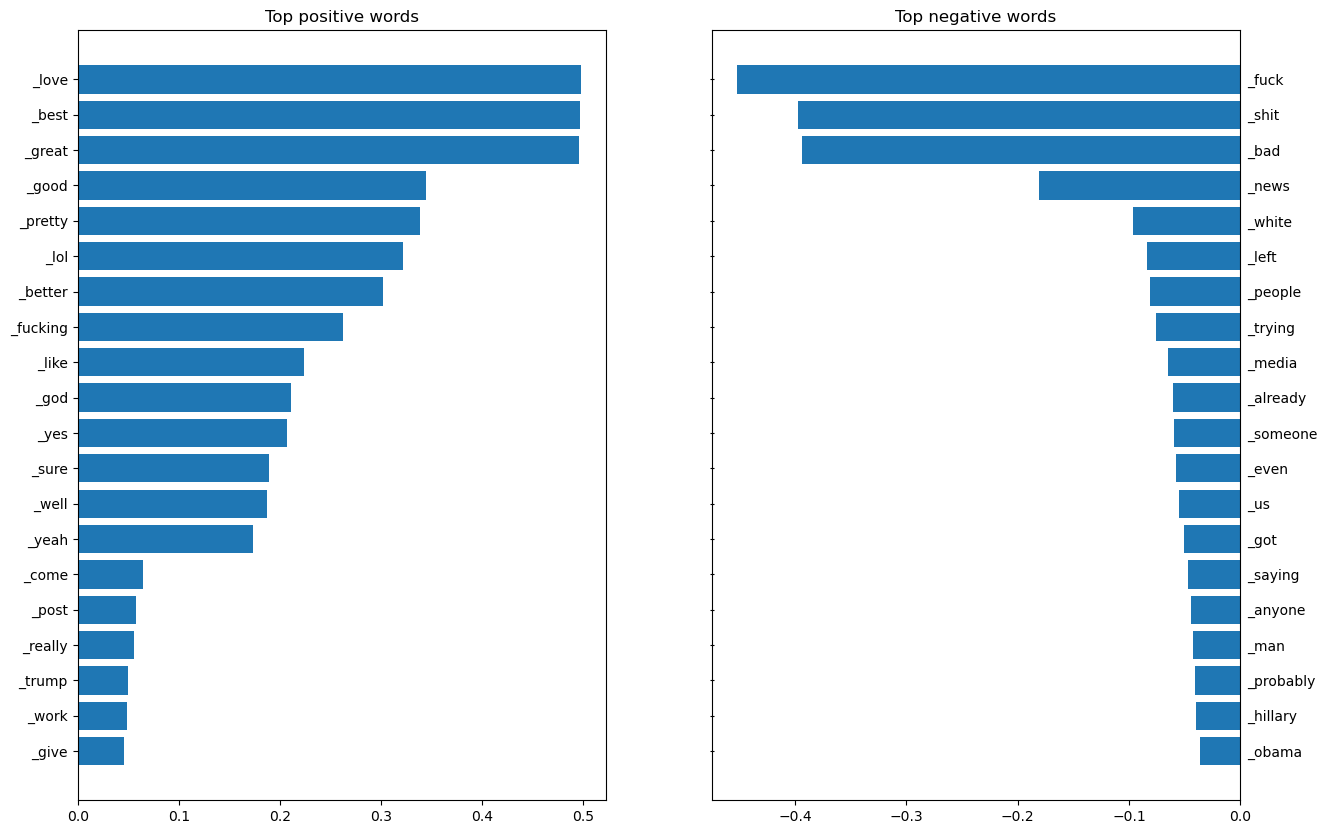

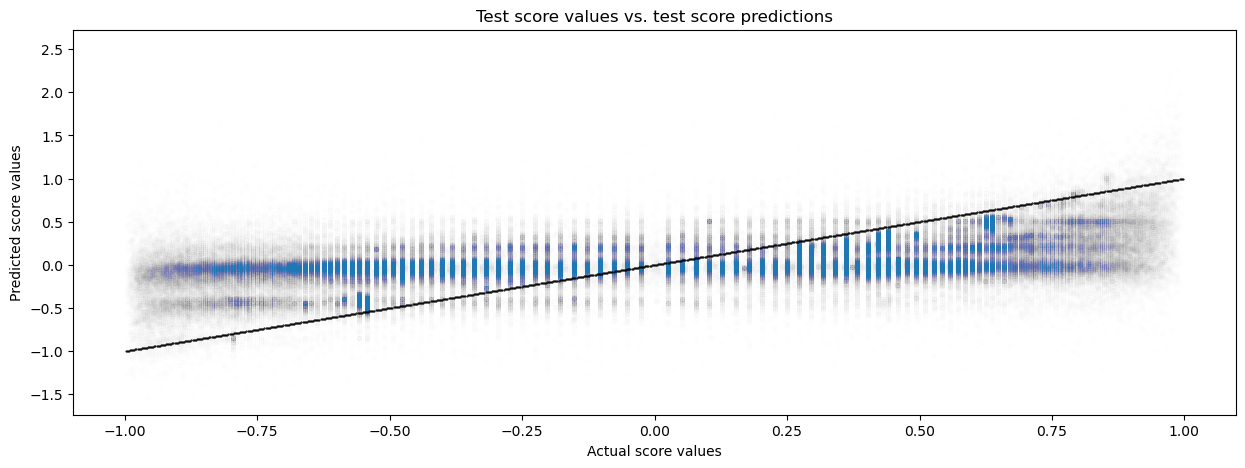

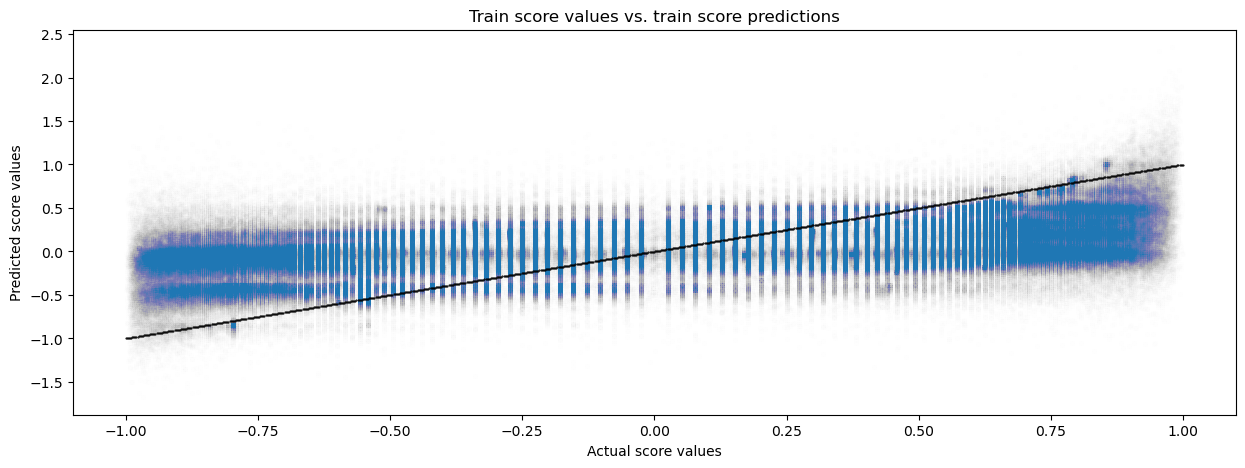

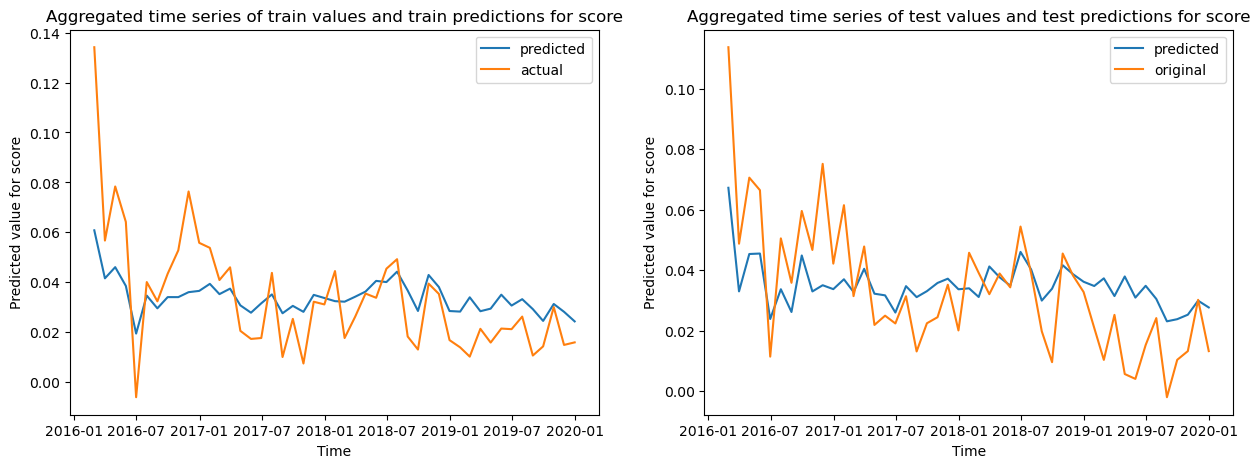

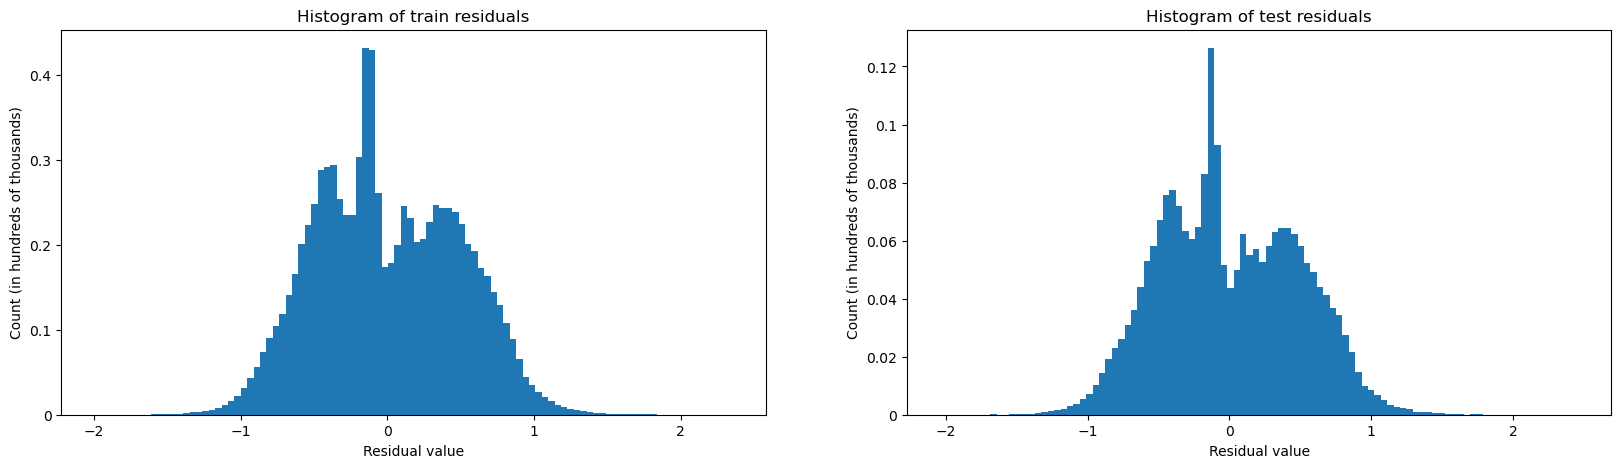

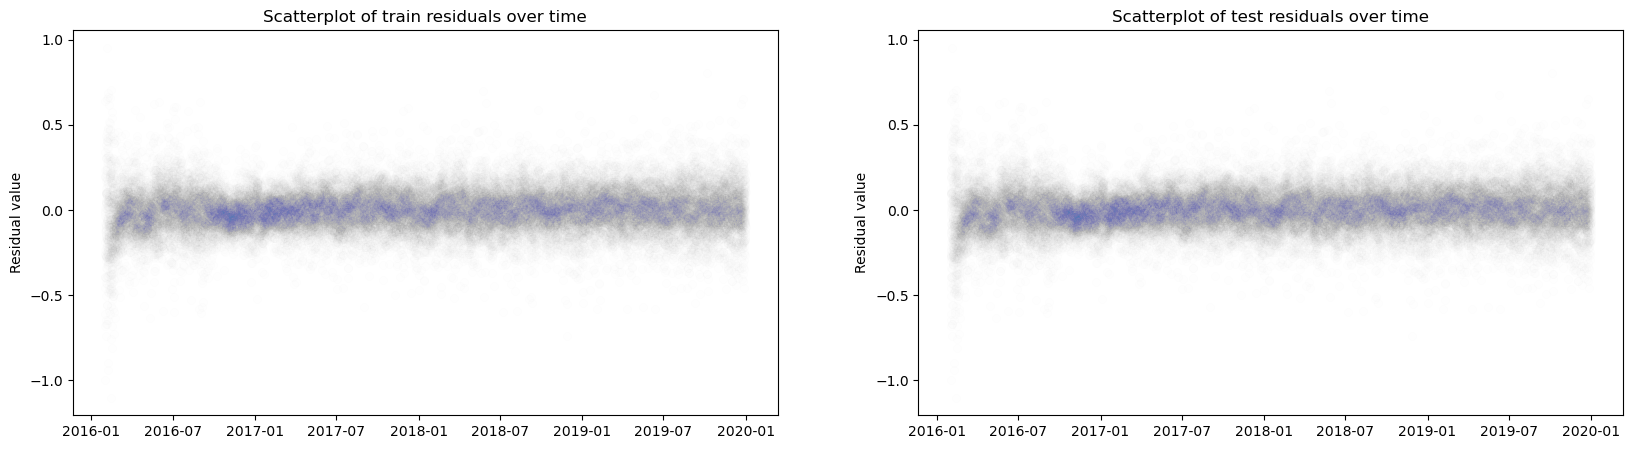

In [43]:
analyze_model(model7_results, line=True, target="score")

## Bigrams

In [44]:
y = vader[(vader.index.isin(bigram_features.index)) & (vader!=0)]
X = bigram_features[bigram_features.index.isin(y.index)]

In [45]:
model8_results = linear_model(X, y)

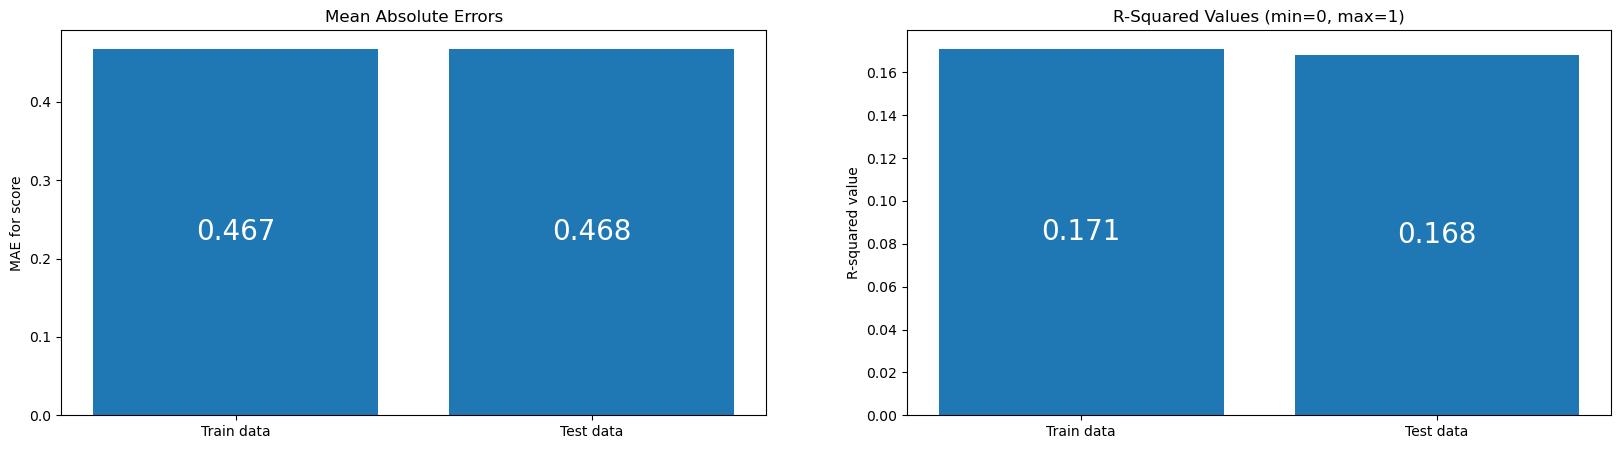

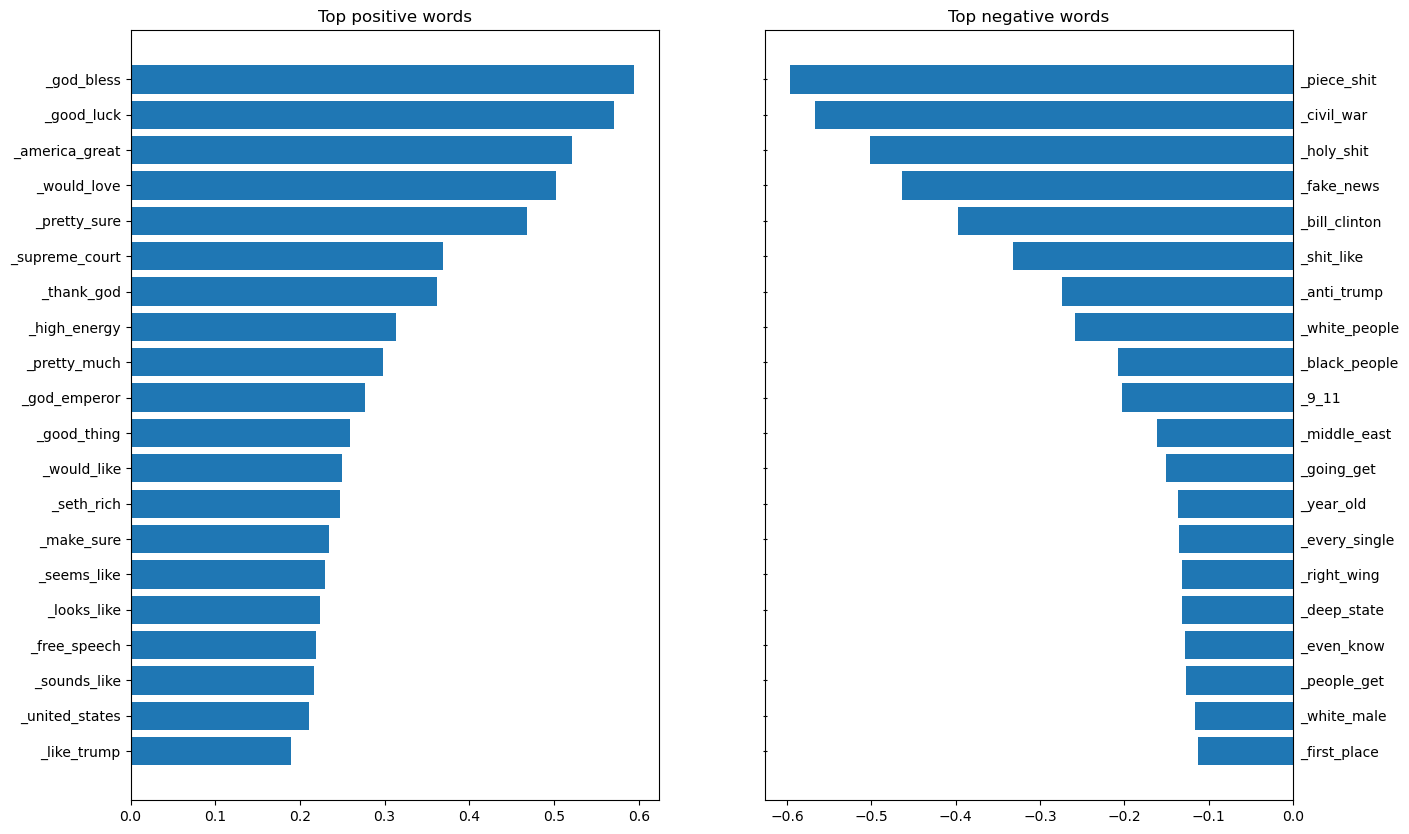

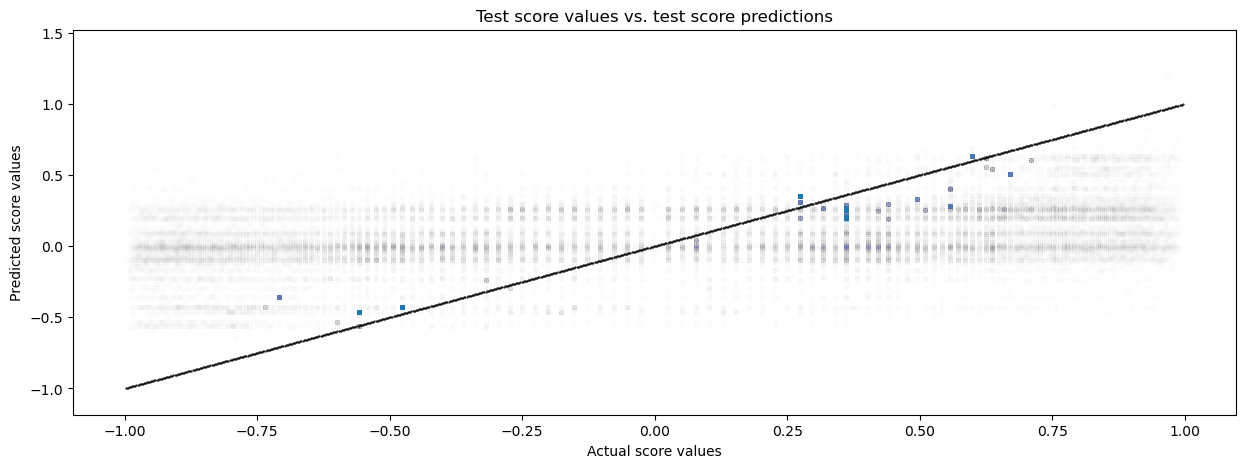

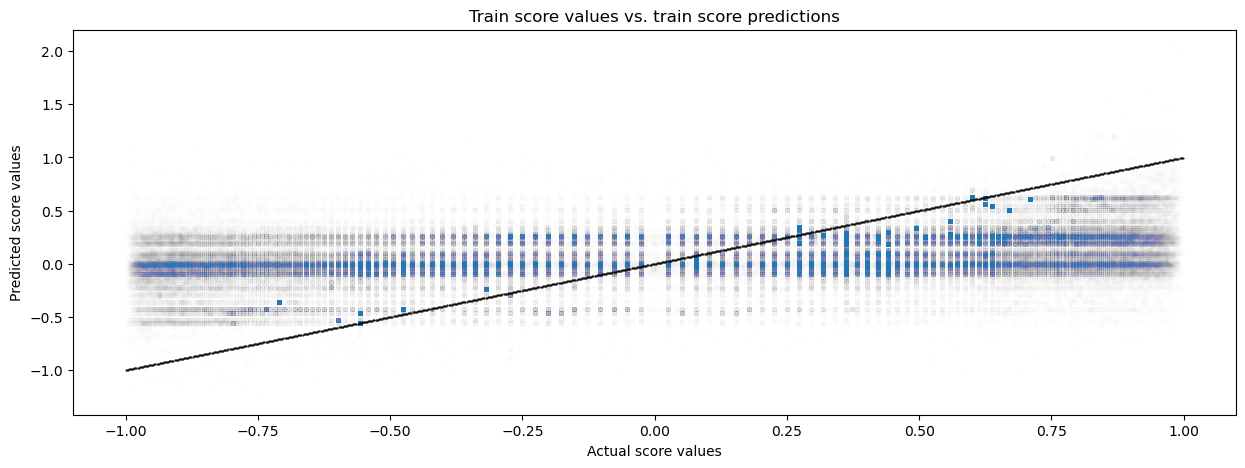

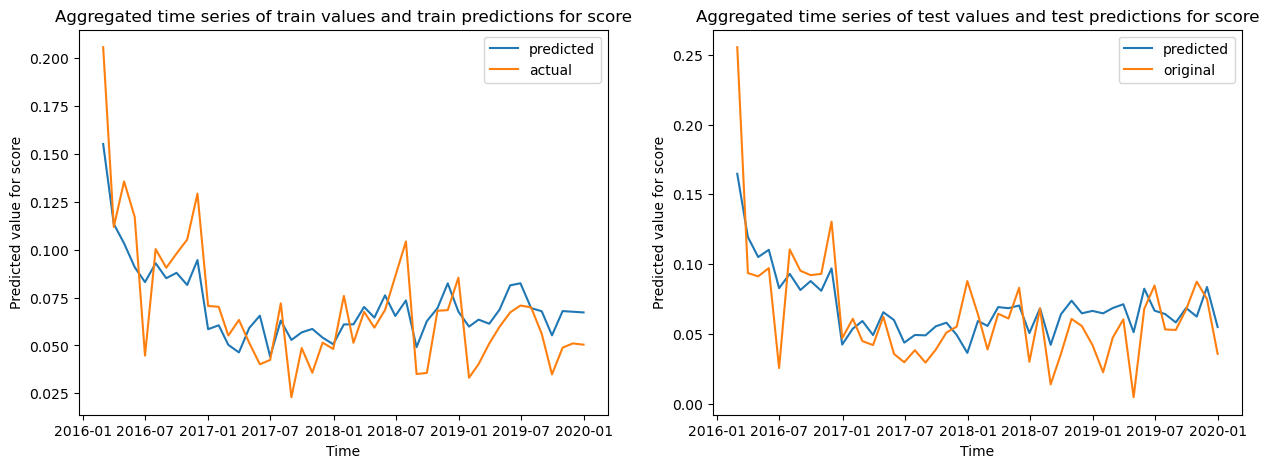

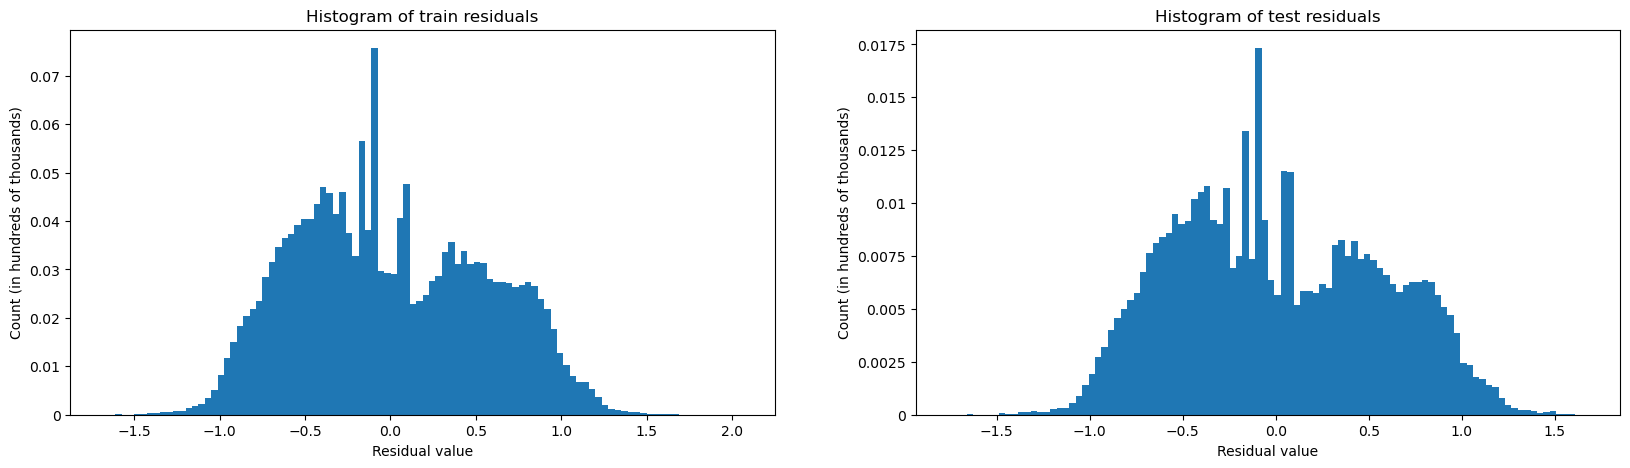

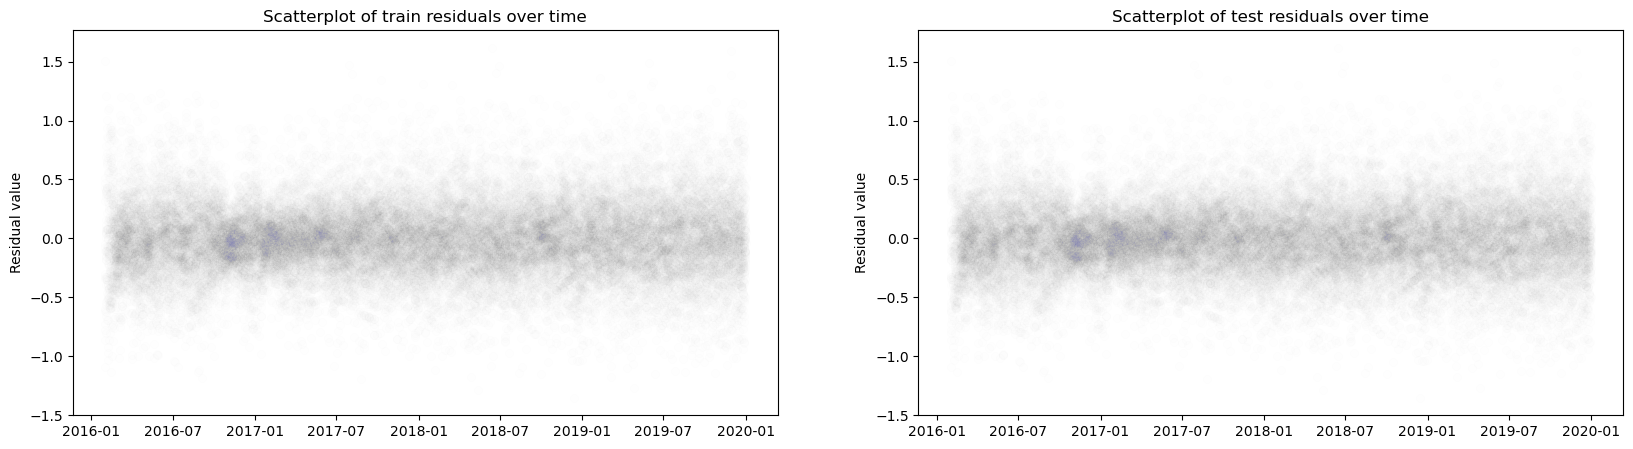

In [46]:
analyze_model(model8_results, line=True, target="score")

## Trigrams

In [47]:
y = vader[(vader.index.isin(trigram_features.index)) & (vader!=0)]
X = trigram_features[trigram_features.index.isin(y.index)]

In [48]:
model9_results = linear_model(X, y)

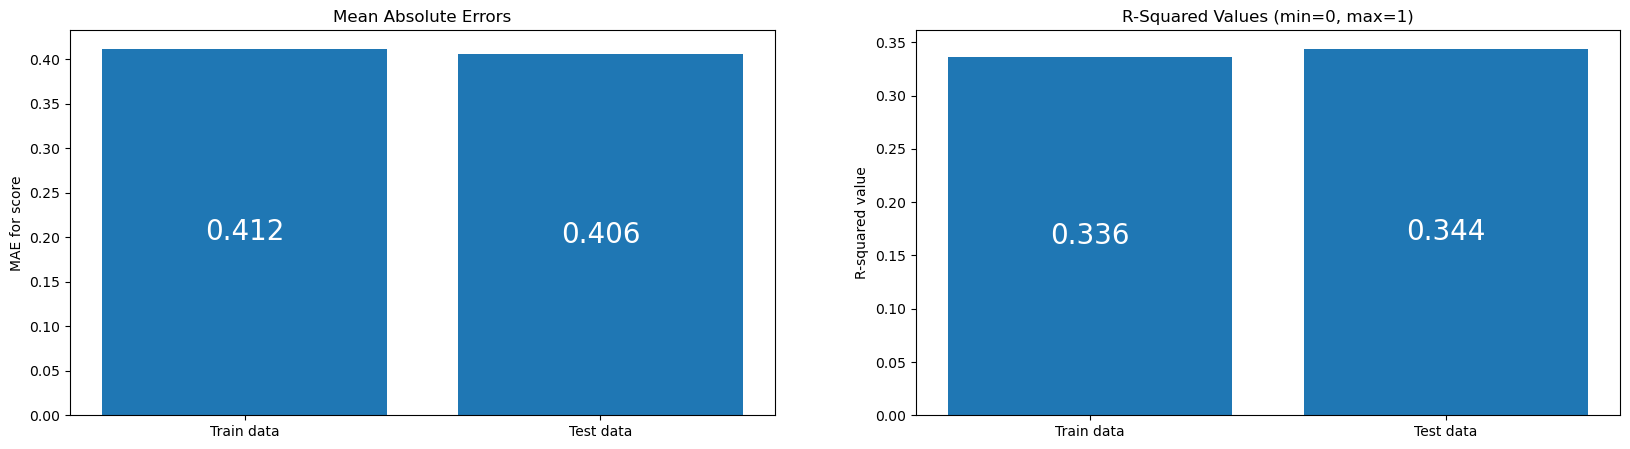

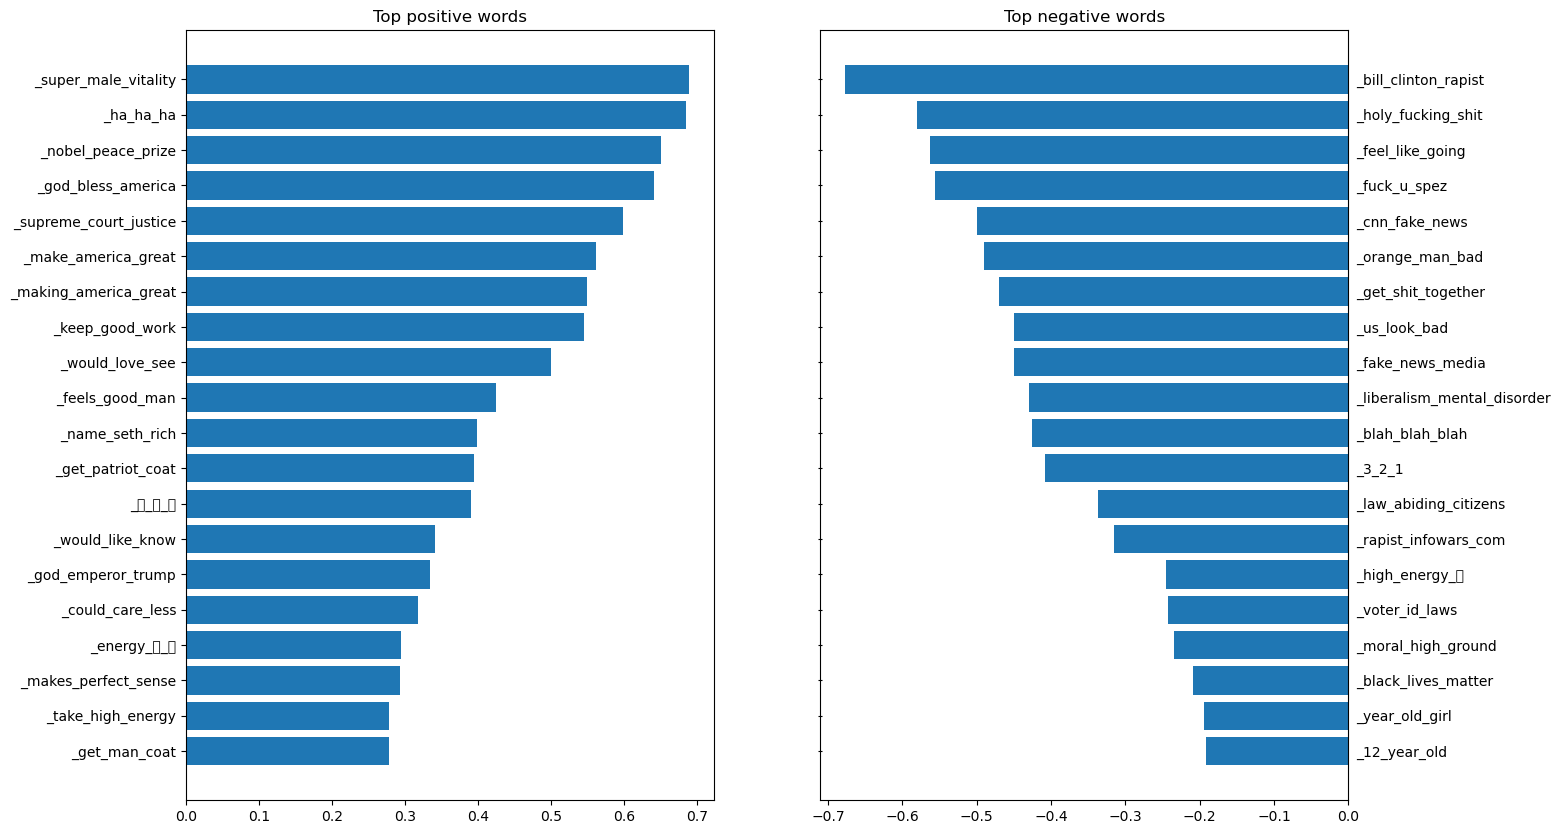

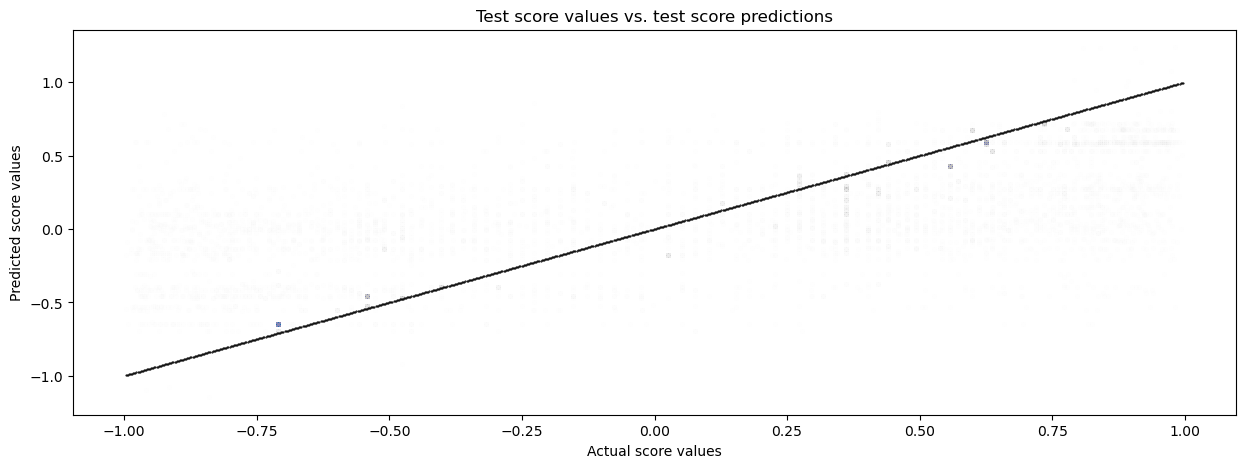

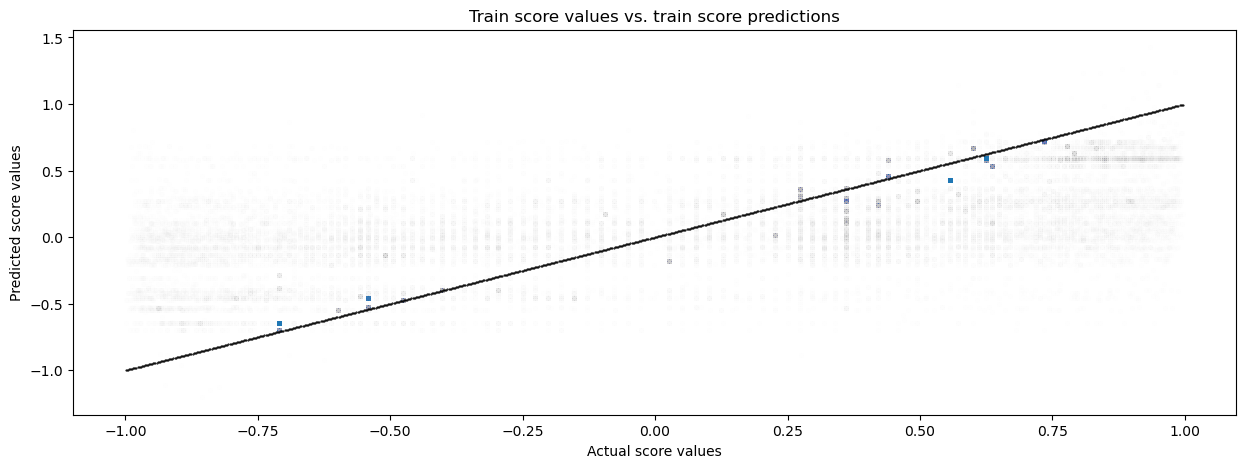

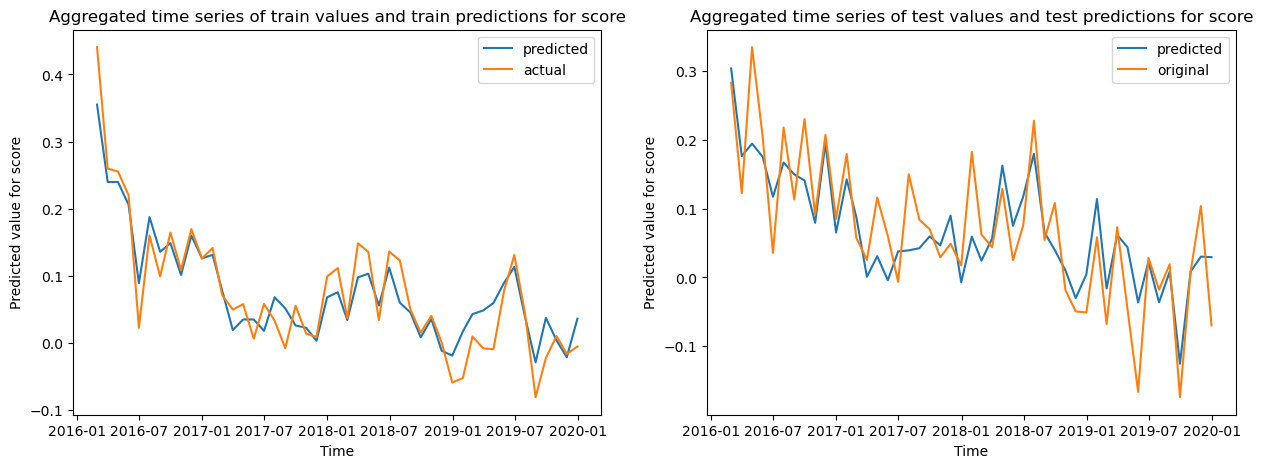

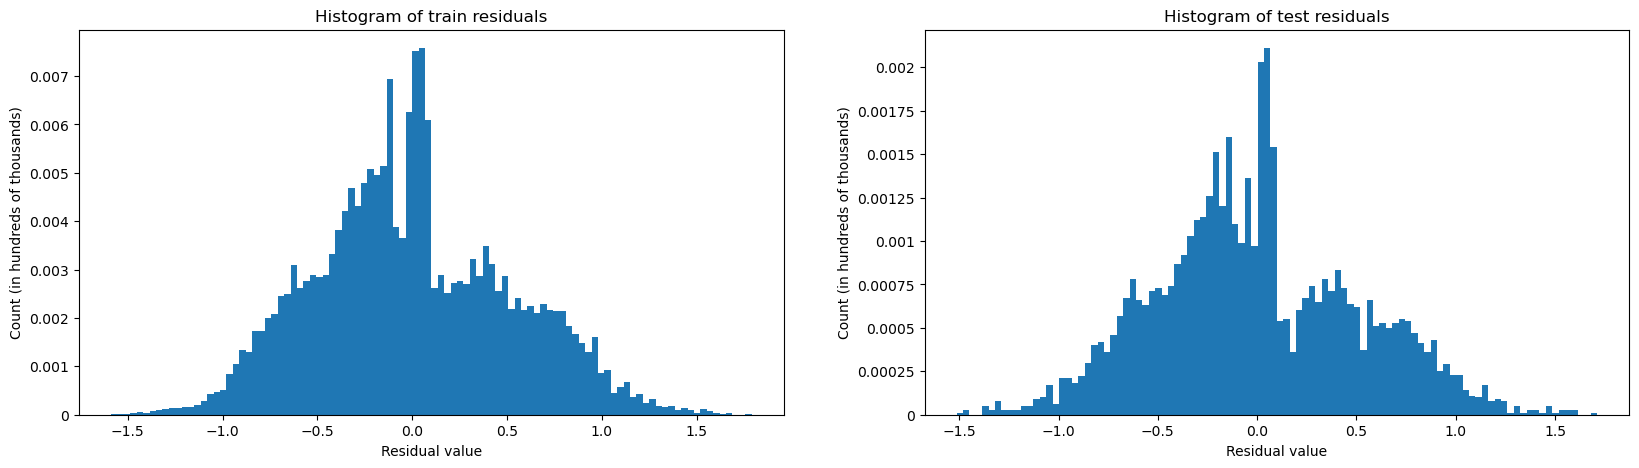

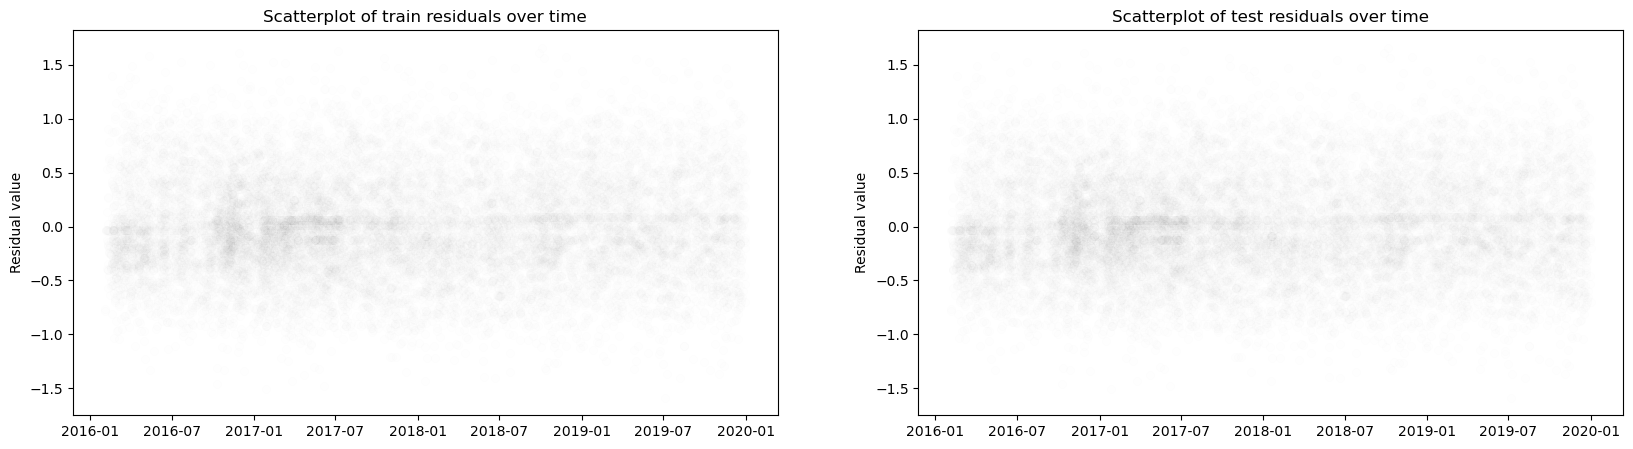

In [49]:
analyze_model(model9_results, line=True, target="score")

# Hyperparameter tuning

Our third model, with sentiment as a target variable, performed much better than our base model. We try some hyperparameter tuning for the unigram, bigram, and trigram model. Although the tuned models have better MAE scores on their training data, they do not have better MAE scores on the test data. Furthermore, all the top words are the same for the tuned models with only slight variations in how they are ordered.

I conclude that hyperparameter tuning did *not* improve our models and I will not be using them.

In [50]:
y = vader[(vader.index.isin(unigram_features.index)) & (vader!=0)]
X = unigram_features[unigram_features.index.isin(y.index)]
print("Hyperparameter tuning for unigrams...")
gridsearch1 = gridsearch(X, y)

y = vader[(vader.index.isin(bigram_features.index)) & (vader!=0)]
X = bigram_features[bigram_features.index.isin(y.index)]
print("Hyperparameter tuning for bigrams...")
gridsearch2 = gridsearch(X, y)

y = vader[(vader.index.isin(trigram_features.index)) & (vader!=0)]
X = trigram_features[trigram_features.index.isin(y.index)]
print("Hyperparameter tuning for trigrams...")
gridsearch3 = gridsearch(X, y)

In [51]:
print(f"test mae: {gridsearch1['test_mae']}, score to beat: {model7_results['test_mae']}")
print(f"test r2: {gridsearch1['test_r2']}, score to beat: {model7_results['test_r2']}")
gridsearch1['coefficients'].sort_values(by='coef', ascending=False).head(20)

test mae: 0.4088757451109354, score to beat: 0.40826588434892663
test r2: 0.2489960289497941, score to beat: 0.249428021535117


gram      coef
54    _great  0.491767
45     _love  0.491291
83     _best  0.488432
11     _good  0.340151
91   _pretty  0.336406
51      _lol  0.318920
64   _better  0.310144
28  _fucking  0.262096
0      _like  0.221665
88      _god  0.211731
90      _yes  0.205073
46     _sure  0.194223
21     _well  0.181622
72     _yeah  0.170038
93     _come  0.062568
94     _post  0.061809
19   _really  0.057050
2     _trump  0.048901
81     _give  0.048625
58     _work  0.047793

In [52]:
print(f"test mae: {gridsearch2['test_mae']}, score to beat: {model8_results['test_mae']}")
print(f"test r2: {gridsearch2['test_r2']}, score to beat: {model8_results['test_r2']}")
gridsearch2['coefficients'].sort_values(by='coef', ascending=False).head(20)

test mae: 0.46879672540462436, score to beat: 0.46771923366564544
test r2: 0.1675628020678016, score to beat: 0.16757422752968598


gram      coef
33      _god_bless  0.584672
84      _good_luck  0.550260
81     _would_love  0.486730
42  _america_great  0.476179
19    _pretty_sure  0.459371
67  _supreme_court  0.354892
89      _thank_god  0.346388
16    _high_energy  0.304352
14    _pretty_much  0.291599
39    _god_emperor  0.267347
44     _good_thing  0.250368
36     _would_like  0.244608
45      _seth_rich  0.237754
24      _make_sure  0.228019
11     _seems_like  0.224374
0      _looks_like  0.216724
28    _free_speech  0.212708
4     _sounds_like  0.205592
10  _united_states  0.205001
52     _like_trump  0.184349

In [53]:
print(f"test mae: {gridsearch3['test_mae']}, score to beat: {model9_results['test_mae']}")
print(f"test r2: {gridsearch3['test_r2']}, score to beat: {model9_results['test_r2']}")
gridsearch3['coefficients'].sort_values(by='coef', ascending=False).head(20)

test mae: 0.4214892409015427, score to beat: 0.4063716304334223
test r2: 0.33489079906763464, score to beat: 0.3435303643285402


gram      coef
23        _god_bless_america  0.531505
0        _make_america_great  0.528101
12     _making_america_great  0.489702
58      _super_male_vitality  0.480847
48        _nobel_peace_prize  0.471360
30                 _ha_ha_ha  0.466486
89    _supreme_court_justice  0.465731
10           _would_love_see  0.443911
52           _keep_good_work  0.388370
11           _name_seth_rich  0.342238
47           _feels_good_man  0.293168
61          _could_care_less  0.214645
76          _would_like_know  0.212329
15    _united_states_america  0.203178
92        _god_emperor_trump  0.196393
28           _would_like_see  0.194081
24         _get_patriot_coat  0.186771
86        _pretty_much_every  0.185770
6   _president_united_states  0.181860
85      _makes_perfect_sense  0.168063